# Fraud Detection Using Machine Learning and AWS Automation

This notebook is currently under narrative development. The coding parts however have been completed already.

# 1. Introduction

## 1.1 Problem Motivation And Significance

Cybersecurity is built on four fundamental pillars, often referred to as **CIAA**:

- **Confidentiality** – Ensuring sensitive data is only accessible to authorized parties.
- **Integrity** – Preventing unauthorized modification or tampering with data.
- **Availability** – Ensuring systems and services remain operational and accessible.
- **Accountability (Non-repudiation)** – Ensuring actions within a system are traceable and attributable to the responsible entity, so no one can deny having performed a particular action.

Although the classic **CIA Triad** is widely referenced, following Wheeler [7], we include **Accountability** as a fourth pillar to emphasize the importance of tracking **"who did what"** and enforcing responsibility.

### 1.2 Where Does Fraud Detection Fit?
Fraud detection is primarily concerned with **Integrity and Accountability**:
- **Integrity:** Fraud involves unauthorized alterations to financial transactions (e.g., illicit modifications, false transactions, or identity theft). A fraud detection system preserves data integrity by **identifying and preventing fraudulent activity**.
- **Accountability:** Fraud prevention mechanisms ensure **legitimate users are held responsible for transactions**, and fraudulent actors are identified, logged, and prevented from bypassing security controls.

Financial fraud can be part of a larger security attack, such as insider threats or breaches, where multiple cybersecurity pillars are impacted. While Confidentiality and Availability are not the primary concerns of fraud detection, they can come into play in such scenarios. Confidentiality may have already been compromised through identity theft, data breaches, or credential leaks, ultimately enabling fraudulent transactions. Availability can be affected if fraud triggers an indication of compromise, leading to business disruptions, the dispatch of incident response teams, and in some cases, temporary account suspensions to contain potential threats. While account shutdowns are not typically an immediate response, fraud alerts can escalate into security investigations, affecting overall system operations.

The focus of this project is fraud prevention by detecting patterns that likely indicate instances of fraud. We are not concerned with Confidentiality or Availability, nor is our fraud detection system designed as part of a broader security infrastructure. However, the choice of model and the evaluation metrics we use will be made with the understanding that a fraud detection system operates within a larger business and security environment. ***Its performance will have a direct impact on both security operations and business outcomes***, influencing incident response, financial risk management, and operational efficiency. 

## 1.3 Tackling Fraud from a Security Risk Management Perspective

While fraud is both a business risk and a security threat, not every instance of fraud carries the same weight in terms of financial and operational impact. From a Security Risk Management (SRM) perspective, the goal is not to blindly chase every potential fraud case—much like dogs chasing cars—but rather to systematically identify, assess, and prioritize threats. The reason is simple: every institution operates under resource constraints, whether human, financial, or technological. Prioritization based on impact is not just a best practice but a necessity, ensuring resources are directed where they provide the greatest return in risk reduction.


Before committing resources to mitigation, we must evaluate the impact of each threat against a predefined risk tolerance threshold set by the business, which varies depending on its risk appetite and operational environment. If the overall impact of a threat falls below this threshold, further risk reduction may not be justifiable in terms of cost and effort. Conversely, if a threat exceeds the acceptable risk level, mitigation becomes a strategic priority. However, even after mitigation efforts are applied in the right direction, some level of residual risk will often remain. This inherent risk is what businesses typically accept and may choose to transfer to another party, such as through cybersecurity insurance. This systemic approach achieves optimal resource allocation by balancing security effectiveness with business practicality. It allows organizations to focus on mitigating the most consequential fraud risks within the acceptable business parameters to maintain operational efficiency.

### 1.3.1 Risk Identification and Assessment

From a **security risk** standpoint, fraud introduces **financial risk, reputational damage, and regulatory non-compliance**. To effectively mitigate fraud risk, one must first **identify** the source and type of the risk. In particular, fraud can manifest in various ways, including:

- **Unauthorized transactions**  
- **Identity theft and account takeover**  
- **Money laundering**  
- **Synthetic fraud** (fake identities used for financial manipulation)  

This project is specifically concerned with **unauthorized transactions**, with a focus on **fraudulent credit card transactions**.  

Once risks are identified, the next step is to **assess their impact**. Fraud risks are typically evaluated based on two key dimensions:  

- **Likelihood**: The probability of fraudulent activity occurring.  
- **Impact**: The financial, legal, and reputational damage if fraud is not detected.  

Our effort in building an **ML-based fraud detection model** directly contributes to **likelihood estimation**—the ability to quantify the probability that a given transaction is fraudulent. Once fraud likelihood is measured as a probability, businesses can use this to **estimate financial risk in dollar terms**, making it possible to assess potential harm and make data-driven security decisions. Also having the probabilty of a fraudulend event at hand, we can measure the reliability of our estimations using ***calibration curves*** or ***Brier Scores***. This improves the robustness of the decision-making process. 

### 1.3.1.1 Evaluation Metrics Selection: Balancing Business and Security Concerns

The above discussion directly informs the choice of **evaluation metrics** for our fraud detection system. Since fraud detection operates within **business and security constraints**, our metric selection must strike a **deliberate balance** between **detection accuracy, operational efficiency, and cost considerations**.

A **fraud detection model** that **maximizes recall** at the expense of precision may generate **too many false positives**, leading to:
- **Excessive manual reviews**, increasing operational costs.
- **Alarm fatigue**, where analysts become overwhelmed by false alarms, leading to potential oversight of actual fraud.
- **Customer dissatisfaction**, as legitimate transactions may be unnecessarily flagged, causing friction in the user experience.

Conversely, a model that **favors precision too aggressively** risks:
- **Missing actual fraud cases**, leading to direct **financial losses**.
- **Regulatory non-compliance**, where undetected fraudulent activity results in **legal penalties** or breaches of financial oversight requirements.

#### 1.3.1.1.1 Choice Threshold for Acceptable Performance

In light of the previous elaborations, we know that fraud detection models do not operate in isolation but rather within a broader financial and security ecosystem. Below are key considerations for setting an optimal decision threshold, presented in a more narrative style:

1. **Business Operations & Cost-Benefit Tradeoff**:
False positives incur manual review costs, while false negatives result in direct financial loss. Consequently, the decision boundary should be positioned at a point where the cost of reviewing additional flagged transactions does not exceed the financial harm of allowing fraudulent activity to go undetected.

2. **Alarm Fatigue and Incident Response Efficiency**:
Fraud teams must concentrate on legitimate threats instead of spending valuable time on low-risk false positives. When a threshold is poorly calibrated and generates an excessive number of alerts, analysts can become overburdened, causing delays in response and reducing the overall effectiveness of fraud detection efforts.

3. **Regulatory & Compliance Constraints**:
Certain financial institutions are legally obligated to investigate transactions once they surpass a specified fraud probability. Some regulatory frameworks also mandate minimum fraud detection accuracy levels to remain compliant with anti-money laundering (AML) or other financial risk regulations, underscoring the need to set thresholds that meet both operational and legal standards.

4. **Adaptive Thresholding Based on Transaction Value**:
High-value transactions may justify a lower threshold to ensure that potential fraud is flagged even at a relatively low confidence level. Conversely, low-value transactions can have a higher threshold, minimizing unnecessary reviews for cases in which the financial risk is comparatively minor.

5. **Calibration and Reliability of Probabilistic Outputs**:
Lastly, the model’s probability scores must accurately mirror real-world fraud likelihood. Calibration techniques—such as Platt scaling, isotonic regression, and the use of Brier Scores—are critical to confirm that a predicted fraud probability of, for example, 80% genuinely reflects an 80% chance of fraudulent activity. This level of reliability is crucial for maintaining confidence in the thresholding strategy.

#### 1.3.1.1.2 Practical Implementation of Cost-Sensitive Thresholding
Instead of using a **fixed threshold (e.g., 0.5)**, one may adopt a **dynamic thresholding approach** in consideration for the following:
- **Cost-sensitive learning**, where the model is trained to weigh false positives and false negatives differently.
- **Risk-adjusted decision rules**, where fraud scores are **compared against risk tolerance levels** rather than a universal cutoff.
- **Threshold tuning experiments**, using **Precision-Recall curves**, **ROC curves**, and **expected monetary loss calculations** to **empirically determine the optimal operating point**.


## 1.4 Why Using Machine Learning Approaches?

Historically, fraud detection has relied on **rule-based systems**, which involve manually crafted logic to identify fraudulent transactions. However, these systems suffer from noticeable limitations:

- Inflexibility: Rule-based systems struggle to adapt to evolving fraud tactics. Fraudsters frequently modify their techniques, rendering static rules obsolete.  
- High False Positive Rates: Many legitimate transactions are incorrectly flagged as fraudulent, leading to customer frustration and increased operational costs.  
- Scalability Issues: Rule-based methods require frequent manual updates, making them inefficient for large-scale financial institutions handling millions of transactions per day.  

With the increasing sophistication of fraudulent activities, rule-based systems alone are no longer sufficient. This is where Machine Learning (ML) offers a powerful alternative. It helps identify patterns beyond manually defined rules and enabling adaptive, scalable, and automated fraud detection.

### 1.4.1 Challenges in ML-based Fraud Detection

Despite the **promise of ML models**, several challenges make fraud detection complex and difficult.

### 1.4.1.1 Extreme Class Imbalance

Fraudulent transactions are rare in real-world datasets, often accounting for less than 1% of all transactions. As a result, standard ML models tend to favor the majority class—non-fraud cases—due to the way they optimize their learning objectives. Most machine learning algorithms operate by minimizing a cost function (or maximizing a utility function) over a given search space, aiming to find an optimal decision boundary. However, in highly imbalanced datasets, the model may incorrectly perceive a suboptimal boundary as optimal simply because the majority class dominates the training data. Even if fraudulent cases are misclassified, the overall cost function remains low, leading the model to believe it has learned an effective decision boundary. This ultimately results in poor fraud detection performance, as the model fails to give sufficient weight to rare fraud instances.

#### **Impact of Class Imbalance**
- **Model Bias Towards Majority Class**: Since fraudulent transactions are **vastly outnumbered**, ML models may **learn to classify all transactions as "non-fraud"**, achieving high overall accuracy while **failing at fraud detection**.  
- **Misleading Accuracy Metrics**: A model predicting **99% of transactions as non-fraud** may still appear highly accurate—yet completely **fail at detecting fraud**.
- **Limited Data for Minority Class (Fraud Cases)**: Since fraud instances are **scarce**, models have **fewer examples to learn meaningful patterns**, making training less effective.

#### **1.4.1.1.1 Strategies to Address Class Imbalance**

Several approaches can help mitigate the challenges posed by class imbalance in fraud detection. Depending on the dataset and business constraints, a combination of these methods may be beneficial:  

1. **Resampling Techniques**
   
One possible approach is **resampling**, which involves modifying the dataset to create a more balanced class distribution:  
- **Oversampling (e.g., SMOTE, ADASYN):** These techniques generate synthetic fraud cases to compensate for the rarity of fraudulent transactions, helping the model learn meaningful patterns from a more balanced dataset.  
- **Undersampling:** By reducing the number of non-fraud transactions, the dataset becomes more evenly distributed, potentially preventing the model from being biased toward the majority class. However, this approach may lead to information loss if too many legitimate transactions are removed.  

2. **Algorithmic Adjustments**
   
Adjusting the model’s learning process can also be an effective way to address class imbalance:  
- **Class-weighted models:** Assigning higher misclassification penalties to fraud cases can encourage the model to pay greater attention to them, despite their scarcity in the dataset.  
- **Cost-sensitive learning:** Instead of treating all classification errors equally, modifying the loss function to reflect the **higher cost of missing fraud cases** may improve detection rates.  

3. **Anomaly Detection Approaches**

Given that fraud cases are inherently rare, some strategies focus on identifying them as **outliers** rather than learning from labeled examples.  **Unsupervised learning techniques** such as **Isolation Forests** and **Autoencoders** may help detect fraud by recognizing deviations from normal transaction patterns without requiring a labeled dataset.  This can be particularly useful in scenarios where fraud patterns are constantly evolving, making it difficult to maintain an up-to-date labeled dataset for supervised learning.  

Ultimately the choice of strategy depends on the **specific characteristics of the data, the operational constraints of the business, and the acceptable trade-offs between false positives and false negatives**. In many cases, combining multiple techniques—such as **oversampling with cost-sensitive learning** or **anomaly detection alongside supervised models**—can yield the best results.  

### **1.4.1.2 Concept Drift**
Fraud tactics **constantly evolve**, requiring ML models to **adapt** to **changing patterns**. Static models risk becoming **ineffective** as fraudsters develop **new strategies**.

#### Types of Concept Drift in Fraud Detection
- **Sudden Drift**: For example, a fraud ring discovers a loophole in a transaction system, **exploits it aggressively**, causing fraud patterns to shift abruptly.  
- **Gradual Drift**: For instance, over time, fraudsters **slowly modify transaction behaviors**, making older fraud detection rules **less effective**.  
- **Recurring Drift**: an example instance would be **Seasonal fraud**—fraud patterns during holiday shopping periods differ from those in **low-activity months**.  

#### Challenges Posed by Concept Drift
- **Static ML models become outdated**, reducing detection accuracy.  
- **Fraud patterns change unpredictably**, making traditional feature engineering less effective.  
- **Old labeled data may no longer reflect new fraud behavior**, requiring **continuous learning** strategies.

#### Strategies to Handle Concept Drift:
- **Frequent Model Retraining**:  we can implement **scheduled retraining intervals** (e.g., weekly or monthly) using the latest fraud trends.  
- **Drift Detection Algorithms**:  Monitoring model **performance metrics over time** to **detect drift early** can be a solution.  Also, using **adaptive learning techniques** that trigger **retraining only when drift is detected** can be helpful.
- **Online & Incremental Learning**:  Instead of retraining the entire model, **incrementally updating model weights** as new fraud cases emerge.
- **Hybrid Models (Supervised + Unsupervised)**:  We can combine **historical fraud data (supervised learning)** with **anomaly detection techniques** to catch unseen fraud trends.

### 1.4.1.3 Scalability And Real-Time Processing Constraints

Many financial institutions require **real-time fraud detection** to **prevent fraudulent transactions before they are approved**. However, ML-based fraud detection faces **scalability challenges**. Some key Scalability Issues include the following.

- **High Computation Costs**: ML models—especially **deep learning approaches**—require **significant processing power**, making real-time scoring computationally expensive.  
- **Latency Constraints**: Fraud detection must happen **within milliseconds** to avoid **delays in payment processing**.  
- **Data Volume & Speed**: Millions of transactions per day generate massive data streams, requiring **efficient feature extraction and real-time inference**.  

#### Strategies for Scalable, Real-Time ML Fraud Detection
- **Optimized Feature Engineering**:  Using **precomputed feature stores** to avoid costly real-time feature extraction.  
- **Efficient Model Deployment**:  relying on **lightweight ML models (e.g., XGBoost over deep learning)** for fast inference.  
- **Streaming Architectures**:  Implementing **Kafka, Apache Flink, or AWS Kinesis** for real-time transaction monitoring.  
- **Hybrid Real-Time & Batch Processing**:  High-risk transactions may get **instant fraud scoring**, while lower-risk transactions **undergo batch processing** for deeper analysis.

## 1.5 **Project Scope and Business Impact**
The focus of this project is **fraud prevention** by detecting patterns that likely indicate instances of fraud. We are **not directly concerned** with **Confidentiality** or **Availability** here, nor is our fraud detection system designed as part of a broader security infrastructure. However, the **choice of model** and the **evaluation metrics** we use will be made with the understanding that a fraud detection system operates within a **larger business and security environment**. Its performance will influence:

- **Incident response actions** (e.g., investigations, resource allocation).
- **Financial risk management** (e.g., assessing potential losses from undetected fraud).
- **Operational efficiency** (e.g., balancing alerts vs. false positives for manual reviews).

## 1.6 Our Approach
To address these challenges, our solution consists of multiple stages:

### Data Preprocessing
- A dedicated **PySpark-based preprocessing pipeline** has been implemented in a separate notebook.
- Includes **data cleaning, transformation, and feature engineering**.
- We reference this preprocessing notebook but keep this notebook focused on modeling.

### ML Model: XGBoost with Sampling Strategies
- We use **XGBoost**, a high-performance gradient boosting model known for handling structured/tabular data efficiently.
- Given the severe class imbalance, we apply **9 different sampling techniques** to compare performance.
- **Cross-validation and hyperparameter tuning** ensure model robustness.

### Evaluation: Fraud Detection-Specific Metrics
- Standard ML metrics like **Accuracy** can be misleading due to class imbalance.
- Instead, we focus on:
  - **Recall** (ability to catch fraudulent transactions).
  - **Precision** (minimizing false positives).
  - **F1-score** (balancing precision and recall).
  - **Geometric Mean (G-Mean)** (to better handle imbalanced data).
- Metrics are interpreted in the context of **security risk and incident response**.

### AWS Integration
- Half of this project involves AWS-based automation.
- The full pipeline leverages:
  - **S3** (storage)
  - **Glue** (ETL processing)
  - **SageMaker** (ML model training & deployment)
  - **IAM** (security & access management)
- These components are fully implemented, and files are structured in the appropriate directories.

# Baseline Models

To assess the effectiveness of the modeling techniques and methods we employ, we need a reliable point of reference. Baseline models serve this purpose by providing a starting benchmark against which we can measure improvements. Subsequent models built using hypterparameter tuning combined with the sampling techniques are then evaluated based on their performance gains or trade-offs relative to this baseline, ensuring that each methodological enhancement contributes meaningful value to the fraud detection system.

## Data Loading

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

In [2]:
# Load data and convert to NumPy arrays
X_train = pd.read_csv("../preprocessing_creditcard_train_features_80.csv").to_numpy()
y_train = pd.read_csv("../preprocessing_creditcard_train_labels_80.csv").to_numpy().ravel()  # Ensure y is 1D

X_test = pd.read_csv("../preprocessing_creditcard_test_features_80.csv").to_numpy()
y_test = pd.read_csv("../preprocessing_creditcard_test_labels_80.csv").to_numpy().ravel()  # Ensure y is 1D

X_validation = pd.read_csv("../preprocessing_creditcard_validation_features_80.csv").to_numpy()
y_validation = pd.read_csv("../preprocessing_creditcard_validation_labels_80.csv").to_numpy().ravel()  # Ensure y is 1D

In [3]:
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, average_precision_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import time

In [4]:
class BaselineModels:
    def __init__(self, model_name, random_state=42):
        """
        Initialize a baseline model by name.
        
        Args:
            model_name (str): One of "XGB", "RF", "Ada".
            random_state (int): Random seed for reproducibility.
        """
        self.model_name = model_name
        self.random_state = random_state
        self.model = None
        self.training_time = None
        self.metrics = None
        self.y_pred_proba = None
        self.y_pred = None
        
    def _initialize_model(self):
        """Return the model instance based on the model name."""
        models = {
            "baseline_XGB": XGBClassifier(random_state=self.random_state, eval_metric='logloss'),
            "baseline_RF": RandomForestClassifier(random_state=self.random_state),
            "baseline_Ada": AdaBoostClassifier(
                     estimator=DecisionTreeClassifier(max_depth=6),
                     random_state=self.random_state,
                     n_estimators=100
            )
        }
        return models.get(self.model_name, None)
    
    def train(self, X_train, y_train):
        """Train the model and record training time."""
        self.model = self._initialize_model()
        if self.model is None:
            raise ValueError(f"Unsupported model name: {self.model_name}")
            
        start_time = time.time()
        self.model.fit(X_train, y_train)
        self.training_time = time.time() - start_time
    
    def _calculate_metrics(self, y_true, y_pred, y_pred_proba):
        """Calculate all metrics and return as dictionary."""
        return {
            'f1': f1_score(y_true, y_pred),
            'precision': precision_score(y_true, y_pred),
            'recall': recall_score(y_true, y_pred),
            'pr_auc': average_precision_score(y_true, y_pred_proba),
            'g_mean': self._calculate_g_mean(y_true, y_pred)
        }
    
    def _calculate_g_mean(self, y_true, y_pred):
        """Helper to compute geometric mean of sensitivity/specificity."""
        cm = confusion_matrix(y_true, y_pred)
        tn, fp, fn, tp = cm.ravel()
        specificity = tn / (tn + fp)
        recall = tp / (tp + fn)
        return np.sqrt(specificity * recall)
    
    def evaluate(self, X_val, y_val, X_train, y_train):
        """Evaluate model and calculate performance differences between val/train."""
        if self.model is None:
            raise ValueError("Model not trained. Call `train()` first.")
            
        # Validation predictions and metrics
        self.y_pred_proba = self.model.predict_proba(X_val)[:, 1]
        self.y_pred = self.model.predict(X_val)
        val_metrics = self._calculate_metrics(y_val, self.y_pred, self.y_pred_proba)
        
        # Training predictions and metrics (for difference calculation only)
        train_pred_proba = self.model.predict_proba(X_train)[:, 1]
        train_pred = self.model.predict(X_train)
        train_metrics = self._calculate_metrics(y_train, train_pred, train_pred_proba)
        
        # Calculate and store differences (validation - training)
        self.metrics = {
            **{'val_' + k: v for k, v in val_metrics.items()},
            **{'diff_' + k: (val_metrics[k] - train_metrics[k]) for k in val_metrics}
        }
    
    def run(self, X_train, y_train, X_val, y_val):
        """Complete training and evaluation workflow."""
        self.train(X_train, y_train)
        self.evaluate(X_val, y_val, X_train, y_train)
        return (
            self.metrics,  # Contains val_* metrics and diff_* metrics
            self.y_pred_proba,
            self.y_pred,
            self.training_time
        )

In [5]:
# Initialize model
baseline_model = BaselineModels("baseline_XGB")

# Train and evaluate
baseline_metrics, baseline_yPredProba, yPred, train_time = baseline_model.run(X_train, y_train, X_validation, y_validation)

baseline_metrics_df = pd.DataFrame(baseline_metrics, index=[0])
baseline_metrics_df["samplingMethod"] = "baselineXGB"
baseline_metrics_df

,val_f1,val_precision,val_recall,val_pr_auc,val_g_mean,diff_f1,diff_precision,diff_recall,diff_pr_auc,diff_g_mean,samplingMethod
0,0.909091,0.978261,0.849057,0.900555,0.921426,-0.090909,-0.021739,-0.150943,-0.099445,-0.078574,baselineXGB


# 3. Model Optimization With Sampling

Below we implement a clas which facilitates a systematic approach to building various models using different sampling methods. A few points are necessary to understand some of the choices we have made in our implementation. 

### Why Combine Sampling Methods with Cross-Validation?

When dealing with **highly imbalanced datasets** (such as fraud detection), **combining sampling techniques with cross-validation in a structured manner** is critical to ensure model reliability and avoid misleading performance estimates. Below are the key reasons why the implementation in `FraudDetectionPipeline` follows the correct approach.

### 1. Avoiding Data Leakage

One of the **biggest mistakes** in imbalanced learning is **applying resampling (e.g., SMOTE, undersampling) before splitting the dataset** into training and validation sets. This introduces **data leakage**, meaning:
- Synthetic samples generated by SMOTE (or similar techniques) **may include information from the validation set**, making the model **see patterns that should remain unseen** during evaluation.
- If we oversample **before** cross-validation splits, fraudulent samples may be **duplicated across training and validation folds**, artificially inflating validation performance.

#### Correct Approach in `FraudDetectionPipeline`:
- **Sampling is applied within each training fold separately**, ensuring that the validation data remains untouched and **truly represents real-world fraud distributions**.

### 2. Ensuring a Fair Model Selection Process

- **Problem:** If we tune hyperparameters on a dataset that has already been oversampled, the model might be **optimized for the artificial dataset**, rather than generalizing well to **real-world fraud detection**.
- **Solution:** The pipeline applies **resampling independently within each training fold**, ensuring that:
  - The model is trained on **balanced** data.
  - It is evaluated on **original, imbalanced** validation data.
  - The **hyperparameters selected are those that work best on real-world class distributions**.

#### **Why does this matter?**
- Fraud detection models are typically deployed **on real-world, imbalanced data**. If we evaluate models only on **synthetic, balanced data**, we risk selecting a model that is **optimized for the wrong objective**—one that might fail completely when faced with the true class distribution.

### 3. Stratified K-Fold Ensures a Representative Evaluation

- Since fraud cases are **rare**, a random split might result in some validation sets containing **very few or even zero** fraud cases, leading to highly unstable performance metrics.
- `StratifiedKFold` ensures that **each fold has the same class distribution**, leading to **reliable** and **consistent** performance estimates across cross-validation.

## Pipeline Construction

In [6]:
import numpy as np
import xgboost as xgb
from sklearn.model_selection import (
    train_test_split, 
    StratifiedKFold
    )
from sklearn.metrics import (
    classification_report,
    average_precision_score,
    f1_score,
    precision_score,
    recall_score,
    confusion_matrix
    )

from imblearn.over_sampling import (
    SMOTE, 
    ADASYN, 
    RandomOverSampler, 
    BorderlineSMOTE
    )
from imblearn.under_sampling import (
    RandomUnderSampler, 
    TomekLinks, 
    NearMiss
    )
from imblearn.combine import (
    SMOTEENN, 
    SMOTETomek
    )

In [69]:
class FraudDetectionPipeline:
    def __init__(self, sampling_method, random_state=42, early_stopping_rounds=5, n_splits=3):
        self.sampling_method = sampling_method
        self.random_state = random_state
        self.early_stopping_rounds = early_stopping_rounds
        self.n_splits = n_splits

        self.best_model = None
        self.best_score = -1
        self.best_params = None

    def _get_sampler(self):
        """Return the appropriate sampler based on the sampling_method provided."""
        samplers = {
            'smote': SMOTE(random_state=self.random_state),
            'adasyn': ADASYN(random_state=self.random_state),
            'random_oversample': RandomOverSampler(random_state=self.random_state),
            'borderline_smote': BorderlineSMOTE(random_state=self.random_state),
            'nearmiss': NearMiss(),    # Uses default parameters (version=1)
            'random_undersample': RandomUnderSampler(random_state=self.random_state),
            'tomek_links': TomekLinks(),
            'smoteenn': SMOTEENN(random_state=self.random_state),
            'smote_tomek': SMOTETomek(random_state=self.random_state)
        }
        if self.sampling_method not in samplers:
            raise ValueError(f"Unsupported sampling method: {self.sampling_method}")
        return samplers[self.sampling_method]

    def train_with_cv(self, X, y, param_grid):
        """
        Performs Stratified K-Fold cross-validation over the given param_grid 
        and updates self.best_model, self.best_score, and self.best_params with the best result.
        """
        skf = StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=self.random_state)
        sampler = self._get_sampler()

        for params in param_grid:
            print(f"\nTesting parameters: {params}")
            pr_auc_scores = []

            for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
                X_train, y_train = X[train_idx], y[train_idx]
                X_val, y_val = X[val_idx], y[val_idx]

                # Resample
                X_res, y_res = sampler.fit_resample(X_train, y_train)

                model = xgb.XGBClassifier(
                    objective='binary:logistic',
                    use_label_encoder=False,
                    eval_metric="aucpr",
                    early_stopping_rounds=self.early_stopping_rounds,
                    random_state=self.random_state,
                    **params
                )

                # Train
                model.fit(
                    X_res, y_res,
                    eval_set=[(X_val, y_val)],
                    verbose=False
                )

                print("Best iteration:", model.best_iteration)
                print("Best score:", model.best_score)
                
                # Evaluate PR-AUC on the validation fold
                y_proba = model.predict_proba(X_val)[:, 1]
                fold_score = average_precision_score(y_val, y_proba)
                pr_auc_scores.append(fold_score)
                print(f"Fold {fold} PR-AUC: {fold_score:.4f}")

            mean_score = np.mean(pr_auc_scores)
            print(f"Mean PR-AUC: {mean_score:.4f}")

            if mean_score > self.best_score:
                self.best_score = mean_score
                self.best_params = params
                # Retrain final model on the entire dataset with these parameters
                self._train_final_model(X, y)

        print(f"\nBest params: {self.best_params}\nBest PR-AUC: {self.best_score:.4f}")
        return self.best_params, self.best_score

    def _train_final_model(self, X, y):
        """
        Splits the data into train/validation to build the final model
        using the best parameters found.
        """
        # Split data for a final hold-out validation
        X_train, X_val, y_train, y_val = train_test_split(
            X, y,
            test_size=0.2,
            stratify=y,
            random_state=self.random_state
        )

        # Resample
        X_res, y_res = self._get_sampler().fit_resample(X_train, y_train)

        # Define and train the final model
        self.best_model = xgb.XGBClassifier(
            objective='binary:logistic',
            use_label_encoder=False,
            eval_metric="aucpr",
            early_stopping_rounds=self.early_stopping_rounds,
            random_state=self.random_state,
            **self.best_params
        )

        self.best_model.fit(
            X_res, y_res,
            eval_set=[(X_val, y_val)],
            verbose=False
        )

    def evaluate(self, X_test, y_test):
        """
        Evaluate the trained model on the test set and return various metrics.
        """
        if self.best_model is None:
            raise ValueError("You must train the model first using train_with_cv().")

        y_pred = self.best_model.predict(X_test)
        y_proba = self.best_model.predict_proba(X_test)[:, 1]

        # Calculate metrics
        metrics = {
            'f1': f1_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred),
            'recall': recall_score(y_test, y_pred),
            'pr_auc': average_precision_score(y_test, y_proba),
            'g_mean': self._g_mean(y_test, y_pred)
        }

        print(f"\nEvaluation Results ({self.sampling_method}):")
        print(classification_report(y_test, y_pred))
        return metrics

    @staticmethod
    def _g_mean(y_true, y_pred):
        """
        Computes the geometric mean of sensitivity (recall) and specificity.
        """
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        specificity = tn / (tn + fp)
        recall = tp / (tp + fn)
        return np.sqrt(recall * specificity)

### Automating Sampling, Cross Validation, Tuning and Evaluation

In [70]:
from itertools import product

def run_experiments(X_train, y_train, X_val, y_val, pipeline_class, hyperparams_dict, sampling_method='smote', n_splits=3):
    """
    Runs multiple experiments, each with one hyperparameter combination,
    trains and evaluates a FraudDetectionPipeline, and stores results.

    Parameters:
    X_train : np.ndarray
        Training features
    y_train : np.ndarray
        Training labels
    X_val : np.ndarray
        Validation features
    y_val : np.ndarray
        Validation labels
    pipeline_class : class
        The FraudDetectionPipeline class (or similar) to instantiate
    hyperparams_dict : dict
        Dictionary of lists for hyperparameter values.
        For example:
            {
                'max_depth': [6, 7],
                'learning_rate': [0.1],
                'n_estimators': [100, 200]
            }
    sampling_method : str, optional
        Sampling method for the pipeline (e.g., 'smote'), by default 'smote'
    n_splits : int, optional
        Number of CV splits for pipeline, by default 5

    Returns:
    results_dict : dict
        A dictionary where each key is an integer index (0, 1, 2, ...),
        and each value is itself a dictionary containing:
            - "configuration": the chosen hyperparams
            - "metrics": dict of validation metrics
            - "metricsDiff": dict of differences (val - train) / 100
            - "score": chosen metric on validation set (e.g., pr_auc)
    """

    # Expand param dict-of-lists into a list of param-combinations
    keys = list(hyperparams_dict.keys())                # e.g. ["max_depth", "learning_rate", ...]
    values_lists = [hyperparams_dict[k] for k in keys]  # e.g. [[6,7], [0.1], [100,200], ...]

    all_param_combos = list(product(*values_lists))
    # Example: if max_depth=[6,7], learning_rate=[0.1], n_estimators=[100,200],
    # you'll get 4 combinations like:
    # [(6, 0.1, 100), (6, 0.1, 200), (7, 0.1, 100), (7, 0.1, 200)]

    results_dict = {}

    for i, combo in enumerate(all_param_combos):
        # Build a single dictionary of {param -> value}
        params = dict(zip(keys, combo))

        # Instantiate your pipeline
        pipeline = pipeline_class(
            sampling_method=sampling_method,
            n_splits=n_splits
        )

        # 'train_with_cv' expects a list of dicts; we pass [params].
        pipeline.train_with_cv(X_train, y_train, [params])

        # Evaluate on validation
        val_metrics = pipeline.evaluate(X_val, y_val)
        # Evaluate on training to compare metrics
        train_metrics = pipeline.evaluate(X_train, y_train)

        # Calculate differences between val and train (divide by 100)
        # so you can interpret them as "percentage points difference"
        metrics_diff = {}
        for m in ['f1', 'precision', 'recall', 'pr_auc', 'g_mean']:
            val_m = val_metrics[m]
            train_m = train_metrics[m]
            diff_m = abs(val_m - train_m)  # e.g., if difference is 0.03 it amounts to 3% difference
            metrics_diff[m] = diff_m

        # Store everything
        results_dict[i] = {
            "configuration": params,
            "metrics": {  # validation metrics only (or we could store both)
                "val_f1": val_metrics['f1'],
                "val_precision": val_metrics['precision'],
                "val_recall": val_metrics['recall'],
                "val_pr_auc": val_metrics['pr_auc'],
                "val_g_mean": val_metrics['g_mean']
            },
            "metricsDiff": metrics_diff,
            "score": val_metrics['pr_auc']  # choose whichever main metric you prefer
        }

    return results_dict

## Sampling Methods For Tackling Data Imbalance 

Fraud detection datasets are often **highly imbalanced**, meaning fraudulent transactions are much rarer than legitimate ones. To address this, we use **sampling techniques** that fall into three broad categories:

### Over-Sampling (Increasing Minority Class Instances)
These techniques create **synthetic fraudulent transactions** or duplicate existing ones to balance the dataset.

- **Random Over-Sampling (ROS)** → Duplicates minority class samples randomly.
- **SMOTE (Synthetic Minority Over-sampling Technique)** → Generates synthetic samples using k-nearest neighbors.
- **ADASYN (Adaptive Synthetic Sampling)** → A variant of SMOTE that focuses more on harder-to-learn samples.
- **Borderline-SMOTE** → Generates synthetic points near the decision boundary for better class separation

### Under-Sampling (Reducing Majority Class Instances)
These methods **remove non-fraudulent transactions** to balance the dataset.

- **Random Under-Sampling (RUS)** → Randomly removes majority class samples.
- **Tomek Links** → Identifies borderline majority samples and removes them to create a clearer separation.
- **NearMiss** → Selects majority class samples that are closest to the minority class, ensuring balanced learning.

### Hybrid Methods (Combining Over-Sampling & Under-Sampling)
These techniques **apply both over- and under-sampling** to balance the dataset effectively.

- **SMOTE-ENN** → Over-samples with SMOTE and then applies Edited Nearest Neighbors (ENN) to remove noisy samples.
- **SMOTE-Tomek Links** → Over-samples with SMOTE and then applies Tomek Links to clean overlapping data points.

### Comparison of Sampling Techniques

| **Method** | **Category** | **Best For** |
|------------|-------------|--------------|
| **Random Over-Sampling (ROS)** | Over-Sampling | Simple but may lead to overfitting. |
| **SMOTE** | Over-Sampling | Works well but assumes linear interpolation works. |
| **ADASYN** | Over-Sampling | Focuses on harder-to-learn fraud cases. |
| **Borderline-SMOTE** | Over-Sampling | Targets decision boundaries for better fraud detection. |
| **Random Under-Sampling (RUS)** | Under-Sampling | Quick, but may remove useful majority samples. |
| **NearMiss** | Under-Sampling | Selects closest majority samples to minority class. |
| **Tomek Links** | Under-Sampling | Cleans overlapping samples for better separation. |
| **SMOTE-ENN** | Hybrid | Removes noisy synthetic samples after SMOTE. |
| **SMOTE-Tomek Links** | Hybrid | Balances data while ensuring cleaner separation. |

## **Oversampling Techniques**

### SMOTE Algorithm: Synthetic Minority Over-sampling Technique

#### **Steps of the SMOTE Algorithm**
SMOTE generates synthetic minority class samples using interpolation between existing data points. Below are the steps the algorithm follows:

1. **Select a Minority Class Sample**  
   - Randomly choose a sample \( x_i \) from the minority class.

2. **Find k-Nearest Neighbors**  
   - Compute the **Euclidean distance** between $x_i$ and all other minority class samples.
   - Select the **k-nearest neighbors** (commonly $k=5$).

3. **Randomly Select a Neighbor**  
   - Randomly pick one of the k-nearest neighbors, say $x_{nn}$.

4. **Generate a Synthetic Sample**  
   - Compute a new sample along the line segment between $x_i$ and $x_{nn}$:

   $x_{new} = x_i + \lambda \cdot (x_{nn} - x_i)$

     where $\lambda$ is a random number drawn from a uniform distribution \( U(0,1) \).

5. **Repeat Until Desired Over-Sampling is Achieved**  
   - Steps **1-4** are repeated until the required number of synthetic samples is generated.

#### **Computational Complexity**
SMOTE involves **two major computational steps**:

1. **Finding k-Nearest Neighbors**  
   - Brute-force approach: $O(N^2)$ 
   - KD-tree approach: $O(N \log N)$  

2. **Generating Synthetic Samples**  
   - Linear complexity: $O(N)$

Thus, the **total complexity is approximately $O(N \log N)$ if KD-trees are used**, or **$O(N^2)$ if brute-force nearest neighbor search is used**.

#### **Other Important Characteristics**
✔ **Synthetic Sample Generation**  
   - Unlike random oversampling (which duplicates minority class points), SMOTE **creates new synthetic points** through interpolation.  
✔ **Reduces Overfitting Risk**  
   - By introducing new data points, SMOTE prevents classifiers from overfitting to duplicate minority class samples.  
✔ **Linear Interpolation in Feature Space**  
   - The assumption is that the **interpolated samples still belong to the minority class**.  
✔ **Works Well When Data is Clustered**  
   - SMOTE is particularly effective when minority class samples are **grouped closely together**.

#### **What to Be Careful About When Using SMOTE**
**Risk of Generating Unrealistic Samples**  
   - If the minority class distribution is highly **non-linear**, SMOTE might create **synthetic samples that do not represent actual data**.  

**Boundary Distortion**  
   - If the **majority and minority classes overlap**, SMOTE may generate synthetic samples that fall into the majority class region, leading to **misclassification**.  
   - **Solution**: Use **Borderline-SMOTE** or **SMOTE-Tomek Links** to refine sample placement.  

**Curse of Dimensionality**  
   - In high-dimensional spaces, k-nearest neighbors may be **less meaningful**, making interpolation less effective.  
   - **Solution**: Apply **dimensionality reduction (PCA, t-SNE)** before using SMOTE.

**Not So Effective for Small Datasets**  
   - If the minority class has **very few samples**, SMOTE may fail to capture meaningful patterns.  

### **SMOTE Algorithm (Pseudo-Code in Python)**

SMOTE (Synthetic Minority Over-sampling Technique) generates synthetic samples for the minority class using interpolation between existing data points. Below is the formal pseudo-code representation of the algorithm.


```python

    SMOTE(X_minority, N, k=5):
    """
    Input:
        X_minority  ← Set of minority class samples
        N           ← Number of synthetic samples to generate
        k           ← Number of nearest neighbors (default: 5)
    Output:
        X_synthetic ← Set of generated synthetic samples
    """

    X_synthetic = set()  # Initialize empty set for synthetic samples

    for x_i in X_minority:
        neighbors = find_k_nearest_neighbors(x_i, X_minority, k)  # Step 1: Find nearest neighbors
        
        for _ in range(N // k):  # Generate (N/k) synthetic samples per instance
            x_nn = random.choice(neighbors)  # Step 2: Select a random neighbor
            λ = random.uniform(0,1)  # Step 3: Generate a random interpolation factor

            x_new = x_i + λ * (x_nn - x_i)  # Step 4: Create synthetic sample
            X_synthetic.add(x_new)  # Step 5: Add sample to the set

    return X_synthetic

In [ ]:
hyperparams = {
    'max_depth': [6, 7],
    'learning_rate': [0.1, 0.01],
    'n_estimators': [100, 200],
    'subsample': [0.8],
    'colsample_bytree': [0.8],
    'reg_alpha': [2],
    'reg_lambda': [100],
    'gamma': [2],
    'min_child_weight': [2],
    'scale_pos_weight': [0.15]
}

results_smote = run_experiments(
    X_train, y_train,
    X_validation, y_validation,
    pipeline_class=FraudDetectionPipeline,
    hyperparams_dict=hyperparams,
    sampling_method='smote',
    n_splits=10
)

#'results' is a dictionary keyed by integer indices 0..N-1 

# If you want, you can find the best config by 'score'
best_index = max(results_smote, key=lambda i: results_smote[i]["score"])

#print("Best config index:", best_index)

print("Best config details:", results_smote[best_index])

### **Random Over-Sampling (ROS)**

#### **Steps of the Random Over-Sampling Algorithm**
Random Over-Sampling (ROS) increases the number of minority class samples by randomly duplicating existing instances. Below are the steps of the algorithm:

1. **Determine the Imbalance Ratio**  
   - Calculate the **desired number of samples** needed to balance the dataset.

2. **Randomly Select Minority Class Samples**  
   - Randomly sample (with replacement) from the existing **minority class dataset**.

3. **Duplicate Selected Samples**  
   - Append the randomly selected samples to the dataset **until the desired class balance is reached**.

4. **Return the Augmented Dataset**  
   - The dataset now has an increased number of minority class samples, achieving a better class balance.

#### **Computational Complexity**
Since ROS simply **duplicates existing samples**, it is computationally **very efficient**:

1. **Random Sampling with Replacement** → $O(N)$  
2. **Appending to the Dataset** → $O(N)$  

The overall computational complexity therefore is $O(N)$, making ROS one of the simplest and fastest resampling methods.


#### **Other Important Characteristics**
✔ **Very Simple and Fast**  
   - No complex calculations, only **random selection and duplication**.  
✔ **Does Not Alter Data Distribution**  
   - Since ROS only **duplicates** existing samples, it does not introduce synthetic variations.  
✔ **Works Well When Data is Limited**  
   - Effective when the **minority class has very few samples** and creating synthetic samples (e.g., with SMOTE) is not feasible.  

#### **What to Be Careful About When Using ROS**
**Overfitting Risk**  
   - Since ROS **duplicates** existing samples rather than generating new ones, models can **overfit** to repeated instances.  
   - **Solution**: Use ROS **only when the dataset is small**, or combine it with **under-sampling techniques**.  

**Does Not Improve Feature Diversity**  
   - Unlike SMOTE, which creates new synthetic data points, ROS does not introduce **new feature variations**. 

**Can Increase Training Time**  
   - If the dataset becomes too large due to excessive duplication, it may **increase model training time without adding much value**.

We will use hypterparameter tuning, specially regularization, to fight overfitting and weakness of this sampling method in introducing feature diversity. 

In [ ]:
hyperparams = {
        'max_depth': [6, 7],
        'learning_rate': [0.1],
        'n_estimators': [100],
        'subsample': [0.8],
        'colsample_bytree': [0.8],

        # Added regularization/anti-overfitting parameters
        'reg_alpha': [1],      # L1 regularization
        'reg_lambda': [100],       # L2 regularization
        'gamma': [2],          # Min split loss
        'min_child_weight': [2, 4],      # Conservative splits
        'scale_pos_weight': [0.15, 1.8]     # Adjust for class imbalance
    }

results_random_oversample = run_experiments(
    X_train, y_train,
    X_validation, y_validation,
    pipeline_class=FraudDetectionPipeline,
    hyperparams_dict=hyperparams,
    sampling_method='random_oversample',
    n_splits=10)

## **ADASYN: Adaptive Synthetic Sampling**

#### **Steps of the ADASYN Algorithm**
ADASYN (Adaptive Synthetic Sampling) is an enhancement of SMOTE that **focuses more on difficult-to-learn minority class samples** by generating more synthetic data in regions where the class imbalance is higher.

1. **Compute Class Imbalance Ratio**  
   - Determine the number of synthetic samples needed based on the **degree of class imbalance**.

2. **Find k-Nearest Neighbors for Each Minority Sample**  
   - Compute the **k-nearest neighbors** of each minority class sample using Euclidean distance.

3. **Estimate Local Class Imbalance**  
   - For each minority sample $x_i$, calculate **how many of its k-nearest neighbors belong to the majority class**.
   - Compute the imbalance ratio $r_i$:

     $r_i = \frac{\text{\# of majority class neighbors}}{k}$

   - Normalize $r_i$ to determine how many synthetic samples should be generated for each $x_i$.

4. **Generate Synthetic Samples Proportionally**  
   - Assign **more synthetic samples to regions with higher imbalance**.
   - Generate synthetic samples using **linear interpolation**, similar to SMOTE:

     $x_{new} = x_i + \lambda \cdot (x_{nn} - x_i)$

     where $\lambda \sim U(0,1)$.

5. **Return the Augmented Dataset**  
   - The dataset now contains additional synthetic samples, especially in regions of high class imbalance.

### **ADASYN Algorithm (Pseudo-Code in Python)**

```python

    ADASYN(X_minority, X_majority, N, k=5):
    """
    Input:
        X_minority  ← Set of minority class samples 
        X_majority  ← Set of majority class samples
        N           ← Total number of synthetic samples to generate
        k           ← Number of nearest neighbors (default: 5)
    Output:
        X_synthetic ← Set of generated synthetic samples
    """

    # ▸ Step 1: Compute Local Class Imbalance Ratios
    r = {}  # Dictionary to store local imbalance ratios
    for x_i in X_minority:
        neighbors = find_k_nearest_neighbors(x_i, X_minority.union(X_majority), k)
        N_majority = count_majority_neighbors(neighbors, X_majority)
        r[x_i] = N_majority / k  # Compute local imbalance ratio

    # ▸ Step 2: Normalize Imbalance Ratios
    r_total = sum(r.values())  # Total imbalance measure
    G = {x_i: int(N * (r[x_i] / r_total)) for x_i in X_minority}  # Assign synthetic samples proportionally

    # ▸ Step 3: Generate Synthetic Samples
    X_synthetic = set()  # Storage for generated synthetic samples
    for x_i in X_minority:
        if G[x_i] > 0:
            neighbors = find_k_nearest_neighbors(x_i, X_minority, k)
            for _ in range(G[x_i]):  # Generate G[x_i] synthetic samples
                x_nn = random.choice(neighbors)  # Select a random neighbor
                λ = random.uniform(0,1)  # Generate a random interpolation factor
                x_new = x_i + λ * (x_nn - x_i)  # Generate synthetic sample
                X_synthetic.add(x_new)  # Store new sample

    return X_synthetic

#### **Computational Complexity**
ADASYN is computationally similar to SMOTE but adds an extra **imbalance weighting step**.

1. **Finding k-Nearest Neighbors**  
   - Brute-force approach: $O(N^2)$  
   - KD-tree approach: $O(N \log N)$  

2. **Computing Local Class Imbalance**  
   - Iterating over all minority samples: $O(N)$  

3. **Generating Synthetic Samples**  
   - Linear interpolation: $O(N)$  

Thus, the total computational complexity is **$O(N \log N)$ (with KD-trees) or $O(N^2)$ (brute-force k-NN search)**.

#### **Other Important Characteristics**
✔ **More Adaptive than SMOTE**  
   - Unlike SMOTE, ADASYN **generates more synthetic data in harder-to-learn areas**.  
✔ **Improves Model Robustness**  
   - By focusing on difficult minority class samples, ADASYN helps models learn **better decision boundaries**.  
✔ **Useful When the Minority Class is Not Uniformly Distributed**  
   - Works well when some **fraud cases are harder to detect than others**.

#### **What to Be Careful About When Using ADASYN**
**May Generate Noisy Samples**  
   - Since ADASYN **focuses on difficult-to-learn regions**, it may generate **samples in borderline or overlapping regions**, increasing **misclassification risk**.  You can use ***SMOTE-Tomek Links*** or ***SMOTE-ENN*** for data cleaning as a way of fighting off this risk. 

**Sensitive to k-Nearest Neighbor Choice**  
   - The quality of synthetic samples depends on the choice of **k**.  
   - **Solution**: Tune $k$ using **cross-validation**.  

**Not Always Better than SMOTE**  
   - If the minority class is **already well-distributed**, ADASYN may not provide significant advantages over SMOTE.  

In [ ]:
results_adasyn = run_experiments(
    X_train, y_train,
    X_validation, y_validation,
    pipeline_class=FraudDetectionPipeline,
    hyperparams_dict={'reg_lambda': [100], 'n_estimators': [100]},
    sampling_method='adasyn',
    n_splits=10
)

In [126]:
best_index = max(results_adasyn, key=lambda i: results_adasyn[i]["score"])

#print("Best config index:", best_index)

print("Best config details:", results_adasyn[best_index])

Best config details: {'configuration': {'reg_lambda': 100, 'n_estimators': 100}, 'metrics': {'val_f1': 0.3333333333333333, 'val_precision': 0.2052401746724891, 'val_recall': 0.8867924528301887, 'val_pr_auc': np.float64(0.8024480936774885), 'val_g_mean': np.float64(0.9386513408282691)}, 'metricsDiff': {'f1': 0.0077299258558132244, 'precision': 0.008668746101060526, 'recall': 0.06086594937366807, 'pr_auc': np.float64(0.004537302119977049), 'g_mean': np.float64(0.03180895356421343)}, 'score': np.float64(0.8024480936774885)}


### **Borderline-SMOTE: A Focused Synthetic Sampling Method**

#### **Steps of the Borderline-SMOTE Algorithm**
Borderline-SMOTE is a variation of SMOTE that **focuses synthetic sample generation on minority class instances near the decision boundary** (i.e., borderline samples). It aims to improve class separability without generating unnecessary samples in safe regions.

#### **Step 1: Identify the Borderline Minority Samples**
   - For each minority class instance $x_i$:
     - Find its **k-nearest neighbors** (typically $k = 5$).
     - Count how many neighbors belong to the **majority class**.
   - Define **borderline samples** as those where **more than half of the k-nearest neighbors belong to the majority class**.
   - Define **safe samples** as those where most neighbors belong to the minority class (these are not used in Borderline-SMOTE).

#### **Step 2: Generate Synthetic Samples for Borderline Cases**
   - For each borderline minority sample $x_i$:
     - Select **one of its k-nearest neighbors from the minority class**.
     - Generate a synthetic sample using **linear interpolation**:

       $x_{\text{new}} = x_i + \lambda \cdot (x_{nn} - x_i)$

       where $\lambda \sim U(0,1)$.

   - The process is repeated until the **desired number of synthetic samples** is generated.

#### **Step 3: Return the Augmented Dataset**
   - The new dataset includes:
     - Original **majority** and **minority** samples.
     - **Newly generated synthetic samples**, mostly in the **borderline region**.

#### **Computational Complexity**
Borderline-SMOTE is similar to SMOTE but has an additional **borderline detection** step:

1. **Finding k-Nearest Neighbors**  
   - Brute-force approach: $O(N^2)$  
   - KD-tree approach: $O(N \log N)$  

2. **Identifying Borderline Samples**  
   - Iterating over all minority class samples: $O(N)$  

3. **Generating Synthetic Samples**  
   - Linear interpolation: $O(N)$

Thus, the total computational complexity is **$O(N \log N)$ with KD-trees or $O(N^2)$ using brute-force k-NN search**.

#### **Other Important Characteristics**
✔ **More Focused than SMOTE**  
   - Generates synthetic samples **only near decision boundaries**, avoiding unnecessary duplication.  
✔ **Enhances Class Separability**  
   - Strengthens the model’s ability to differentiate between the **minority and majority classes**.  
✔ **Reduces the Risk of Over-Sampling Safe Regions**  
   - Unlike SMOTE, which oversamples all minority samples, Borderline-SMOTE **targets ambiguous cases**.

#### **What to Be Careful About When Using Borderline-SMOTE**
**Still Assumes Linear Interpolation is Valid**  
   - Synthetic samples are placed along a straight line between minority points.  
   - **Solution**: In non-linear distributions, consider **adaptive sampling techniques**.  

**Sensitive to k-Nearest Neighbor Selection**  
   - The **choice of k** affects which samples are labeled as borderline.  
   - **Solution**: Tune $k$ using **cross-validation**.  

**May Over-Sample in Noisy Regions**  
   - If the minority class is **highly scattered**, some borderline samples may be **misclassified noise**.  
   - **Solution**: Combine with **Tomek Links or SMOTE-ENN** to remove overlapping points.  

### **Borderline-SMOTE Algorithm (Pseudo-Code in Python)**

```python

    Borderline_SMOTE(X_minority, X_majority, N, k=5):
    """
    Input:
        X_minority  ← Set of minority class samples
        X_majority  ← Set of majority class samples
        N           ← Number of synthetic samples to generate
        k           ← Number of nearest neighbors (default: 5)
    Output:
        X_synthetic ← Set of generated synthetic samples
    """

    # ▸ Step 1: Identify Borderline Minority Samples
    borderline_samples = set()  # Storage for detected borderline samples
    for x_i in X_minority:
        neighbors = find_k_nearest_neighbors(x_i, X_minority.union(X_majority), k)
        N_majority = count_majority_neighbors(neighbors, X_majority)

        if N_majority > (k / 2):
            borderline_samples.add(x_i)  # Mark as borderline

    # ▸ Step 2: Generate Synthetic Samples for Borderline Cases
    X_synthetic = set()  # Storage for generated synthetic samples
    for x_i in borderline_samples:
        neighbors_min = find_k_nearest_neighbors(x_i, X_minority, k)  # Minority class neighbors only

        for _ in range(N // len(borderline_samples)):  # Distribute synthetic samples equally
            x_nn = random.choice(neighbors_min)  # Select a random minority neighbor
            λ = random.uniform(0,1)  # Generate a random interpolation factor
            x_new = x_i + λ * (x_nn - x_i)  # Generate synthetic sample
            X_synthetic.add(x_new)  # Store new sample

    return X_synthetic

In [ ]:
results_borderline_smote = run_experiments(
    X_train, y_train,
    X_validation, y_validation,
    pipeline_class=FraudDetectionPipeline,
    hyperparams_dict={'reg_lambda': [1.2]},
    sampling_method='borderline_smote',
    n_splits=10
)

In [128]:
best_index = max(results_borderline_smote, key=lambda i: results_borderline_smote[i]["score"])

#print("Best config index:", best_index)

print("Best config details:", results_borderline_smote[best_index])

Best config details: {'configuration': {'reg_lambda': 1.2}, 'metrics': {'val_f1': 0.9019607843137255, 'val_precision': 0.9387755102040817, 'val_recall': 0.8679245283018868, 'val_pr_auc': np.float64(0.8875495707938996), 'val_g_mean': np.float64(0.9315750909313282)}, 'metricsDiff': {'f1': 0.03347680535628883, 'precision': 0.037272393987535124, 'recall': 0.030147097042465765, 'pr_auc': np.float64(0.08676029415027253), 'g_mean': np.float64(0.016074632894526597)}, 'score': np.float64(0.8875495707938996)}


## Undersampling Methods

## **Random Under-Sampling (RUS)**

### **Steps of the Random Under-Sampling Algorithm**
Random Under-Sampling (RUS) **reduces the number of majority class samples** to balance the dataset by randomly removing instances.

#### **Step 1: Determine the Imbalance Ratio**
   - Compute the number of samples needed to **match the minority class size** or achieve a desired class balance.

#### **Step 2: Randomly Select Majority Class Samples**
   - Randomly select a subset of the majority class instances **without replacement** to retain.

#### **Step 3: Remove Excess Majority Samples**
   - Discard the remaining majority class samples **to achieve the target class balance**.

#### **Step 4: Return the Down-Sampled Dataset**
   - The dataset now contains:
     - **All minority class samples** (unchanged).
     - **A reduced subset of majority class samples**, randomly chosen.

### **Random Under-Sampling (RUS) Algorithm (Pseudo-Code in Python)**

```python

    Random_Under_Sampling(X_minority, X_majority, N_target):
    """
    Input:
        X_minority  ← Set of minority class samples
        X_majority  ← Set of majority class samples
        N_target    ← Desired number of majority class samples after down-sampling
    Output:
        X_resampled ← Balanced dataset after under-sampling
    """

    # ▸ Step 1: Determine Sampling Size
    if N_target >= len(X_majority):
        return X_minority.union(X_majority)  # No sampling needed, return original dataset

    # ▸ Step 2: Randomly Select Majority Samples
    X_majority_sampled = random.sample(X_majority, N_target)  # Select N_target majority samples

    # ▸ Step 3: Return the Resampled Dataset
    X_resampled = X_minority.union(set(X_majority_sampled))  # Combine with minority class
    return X_resampled


#### **Computational Complexity**

Since RUS is **just random selection and deletion**, it is one of the most computationally efficient resampling methods.

1. **Random Sampling from the Majority Class**  
   - Using random selection: \( O(N) \)  
   - Removing samples: \( O(N) \)  

Thus, the overall computational complexity is **\( O(N) \)**.

#### **Other Important Characteristics**
✔ **Fast and Memory Efficient**  
   - Does not generate new data, only removes samples.  
✔ **Reduces Training Time**  
   - A smaller dataset means **faster model training**.  
✔ **Simple to Implement**  
   - Requires only random selection, making it an easy method to apply.

#### **What to Be Careful About When Using RUS**
**Risk of Losing Important Information**  
   - Removing too many majority class samples **can discard useful patterns**.  
   - **Solution**: Apply **multiple rounds of RUS** with different random seeds and average results.  

**May Lead to Overfitting**  
   - If too many majority class samples are removed, models may **overfit to a small dataset**.  
   - **Solution**: Use RUS **alongside over-sampling techniques** (e.g., **SMOTE**).  

**Not Always the Best Choice for Highly Imbalanced Data**  
   - If the majority class is much larger than the minority class, **aggressive under-sampling may discard too much data**.  
   - **Solution**: Consider **hybrid methods** like **SMOTE-Tomek Links or SMOTE-ENN**.

In [ ]:
hyperparams = {
        'max_depth': [6],
        'learning_rate': [0.5],
        'n_estimators': [100],
        'subsample': [0.8],
        'colsample_bytree': [0.8],

        # Added regularization/anti-overfitting parameters
        'reg_alpha': [1.5],      # L1 regularization
        'reg_lambda': [100],       # L2 regularization
        'gamma': [4],          # Min split loss
        'min_child_weight': [4],      # Conservative splits
        'scale_pos_weight': [0.2]     # Adjust for class imbalance
    }

results_random_undersample = run_experiments(
    X_train, y_train,
    X_validation, y_validation,
    pipeline_class=FraudDetectionPipeline,
    hyperparams_dict=hyperparams,            
    sampling_method='random_undersample',
    n_splits=10)

## **Tomek Links: Cleaning the Decision Boundary**

### **Steps of the Tomek Links Algorithm**
Tomek Links is an **under-sampling technique** used to **remove overlapping majority class samples** near the decision boundary, thereby improving class separation.

#### **Step 1: Identify Tomek Links**
   - A **Tomek Link** exists between two samples $x_i$ and $x_j$ from **opposite classes** if:
     
     $d(x_i, x_j) = \min_{x} d(x_i, x)$
     
     where $d(x_i, x_j)$ is the Euclidean distance between the two samples, and **no other sample is closer** to either $x_i$ or $x_j$.

#### **Step 2: Remove the Majority Class Sample from Each Tomek Link**
   - If a Tomek Link is found, **the majority class sample in the pair is removed**.
   - This eliminates overlapping data points that may cause misclassification.

#### **Step 3: Return the Cleaned Dataset**
   - The new dataset contains:
     - **All minority class samples** (unchanged).
     - **A reduced set of majority class samples**, with Tomek Links removed.  

### **Tomek Links Algorithm (Pseudo-Code in Python)**

```python

    Tomek_Links(X_minority, X_majority):
    """
    Input:
        X_minority  ← Set of minority class samples
        X_majority  ← Set of majority class samples
    Output:
        X_cleaned   ← Dataset with Tomek Links removed
    """

    # ▸ Initialize Variables
    X_cleaned = X_minority.union(X_majority)  # Start with full dataset
    tomek_links = set()  # Store identified Tomek Links

    # ▸ Step 1: Identify Tomek Links
    for x_i in X_majority:
        x_nn = find_nearest_neighbor(x_i, X_minority)  # Find nearest minority class neighbor

        if find_nearest_neighbor(x_nn, X_majority) == x_i:  
            tomek_links.add(x_i)  # Mark majority sample for removal

    # ▸ Step 2: Remove Majority Class Samples in Tomek Links
    X_cleaned = X_cleaned.difference(tomek_links)  # Remove identified Tomek Links

    return X_cleaned

#### **Computational Complexity**

Tomek Links requires computing pairwise distances, making it more computationally expensive than **Random Under-Sampling (RUS)**.

1. **Finding Nearest Neighbors for Each Sample**  
   - Brute-force approach: $O(N^2)$  
   - KD-tree approach: $O(N \log N)$  

2. **Identifying Tomek Links and Removing Samples**  
   - Linear pass over the dataset: $O(N)$  

Thus, the total computational complexity is **$O(N \log N)$** (if using KD-trees) or **$O(N^2)$** (if using brute-force distance calculations).

#### **Other Important Characteristics**
✔ **Enhances Class Separability**  
   - Removes ambiguous majority class samples **at the decision boundary**, making classification easier.  
✔ **Prepares Data for Over-Sampling**  
   - Often used **before SMOTE** to clean overlapping data before generating synthetic samples.  
✔ **Less Aggressive Than Random Under-Sampling**  
   - RUS **removes samples randomly**, while Tomek Links **only removes borderline cases**.

#### **What to Be Careful About When Using Tomek Links**
**Not Effective for Highly Overlapping Classes**  
   - If the classes **heavily overlap**, Tomek Links **may not remove enough majority class samples**.  
   - **Solution**: Use **SMOTE-Tomek Links**, which combines Tomek Links with over-sampling.  

**Computationally Expensive for Large Datasets**  
   - Tomek Links requires pairwise distance computation, which may be **slow for very large datasets**.  
   - **Solution**: Use **KD-Trees or Approximate Nearest Neighbors (ANN)** to speed up computation.  

**May Remove Useful Samples**  
   - If too many majority class samples are removed, it could **reduce model robustness**.  
   - **Solution**: Tune **Tomek Link thresholds** to avoid excessive data loss.

In [ ]:
results_tomek_links = run_experiments(
    X_train, y_train,
    X_validation, y_validation,
    pipeline_class=FraudDetectionPipeline,
    hyperparams_dict={},
    sampling_method='tomek_links',
    n_splits=10
)

In [131]:
best_index = max(results_tomek_links, key=lambda i: results_tomek_links[i]["score"])

#print("Best config index:", best_index)

print("Best config details:", results_tomek_links[best_index])

Best config details: {'configuration': {}, 'metrics': {'val_f1': 0.8979591836734694, 'val_precision': 0.9777777777777777, 'val_recall': 0.8301886792452831, 'val_pr_auc': np.float64(0.8867120132641051), 'val_g_mean': np.float64(0.9111307399643007)}, 'metricsDiff': {'f1': 0.015076300790586528, 'precision': 0.007480748074807475, 'recall': 0.020271323873382263, 'pr_auc': np.float64(0.00834852515789175), 'g_mean': np.float64(0.0111944820646388)}, 'score': np.float64(0.8867120132641051)}


## **NearMiss: A Focused Under-Sampling Technique**

### **Steps of the NearMiss Algorithm**
NearMiss is an **under-sampling technique** that removes majority class samples **closest to the minority class** to balance the dataset while preserving informative decision boundaries.

There are **three main versions** of NearMiss:

#### **NearMiss-1: Selecting Majority Samples Closest to the Minority Class**

   - For each **majority class instance**, compute its **distance to all minority class instances**.
   - Select **the majority class instances that are closest** to any minority class instance.
   - Remove the rest of the majority class samples.

#### **NearMiss-2: Selecting Majority Samples Closest to Multiple Minority Samples**
   - For each **majority class instance**, compute its **average distance to the k-nearest minority samples**.
   - Select the **majority class instances with the smallest average distance**.
   - Remove the rest of the majority class samples.

#### **NearMiss-3: Selecting Minority Samples Closest to the Majority Class**

   - For each **minority class instance**, compute its **distance to the k-nearest majority class instances**.
   - Remove **majority class instances that are farthest from minority instances**, keeping only those closest to at least one minority sample. 

### **NearMiss-1 Algorithm (Pseudo-Code in Python)**

```python

    NearMiss_1(X_minority, X_majority, N_target):
    """
    Input:
        X_minority  ← Set of minority class samples
        X_majority  ← Set of majority class samples
        N_target    ← Desired number of majority class samples after down-sampling
    Output:
        X_resampled ← Balanced dataset after under-sampling
    """

    # ▸ Step 1: Compute Distances Between Majority and Minority Samples
    distance_map = {}  # Dictionary to store distances
    for x_i in X_majority:
        d_i = compute_distances(x_i, X_minority)  # Compute distances to all minority samples
        min_distance = min(d_i)  # Get the closest minority class distance
        distance_map[x_i] = min_distance  # Store the closest distance

    # ▸ Step 2: Sort Majority Class Samples by Distance
    sorted_majority = sorted(distance_map.items(), key=lambda x: x[1])  # Sort by increasing distance

    # ▸ Step 3: Select the Closest N_target Majority Class Samples
    X_majority_sampled = [x[0] for x in sorted_majority[:N_target]]

    # ▸ Step 4: Return the Resampled Dataset
    X_resampled = X_minority.union(set(X_majority_sampled))  # Combine with minority class
    return X_resampled

#### **Computational Complexity**
NearMiss requires **pairwise distance calculations**, making it more computationally expensive than **Random Under-Sampling (RUS)**.

1. **Finding k-Nearest Neighbors for Distance Calculation**  
   - Brute-force approach: $O(N^2)$  
   - KD-tree approach: $O(N \log N)$  

2. **Sorting & Selecting the Closest Majority Class Samples**  
   - Sorting step: $O(N \log N)$  

Thus, the total computational complexity is **$O(N \log N)$** (if using KD-trees) or **$O(N^2)$** (if using brute-force k-NN search).

#### **Other Important Characteristics**
                                                                                                           
✔ **Preserves Decision Boundaries**  
   - Ensures that **majority class samples near the minority class** are retained.  
✔ **More Structured Than Random Under-Sampling**  
   - Unlike RUS, NearMiss removes samples **based on distance metrics**, not randomly.  
✔ **Useful for Highly Imbalanced Datasets**  
   - Works well when the majority class **significantly outnumbers** the minority class.

#### **What to Be Careful About When Using NearMiss**

**Computationally Expensive for Large Datasets**  
   - Requires **pairwise distance calculations** for all samples.  
   - **Solution**: Use **KD-Trees or Approximate Nearest Neighbors (ANN)** for faster processing.  

**May Remove Important Majority Class Samples**  
   - If a **majority class instance is important for classification**, but is far from any minority instance, it may be removed.  
   - **Solution**: Consider **hybrid methods** (e.g., **NearMiss + Tomek Links**).  

**Not Always the Best Choice for Complex Data Distributions**  
   - If the **decision boundary is highly non-linear**, NearMiss may **over-simplify the data**.  
   - **Solution**: Combine NearMiss with **SMOTE** for balanced data augmentation. 

In [ ]:
hyperparams = {
        'max_depth': [5],
        'learning_rate': [0.3],
        'n_estimators': [100],
        'subsample': [0.8],
        'colsample_bytree': [0.8],

        # Added regularization/anti-overfitting parameters
        'reg_alpha': [2.5],      # L1 regularization
        'reg_lambda': [100],       # L2 regularization
        'gamma': [2.5],          # Min split loss
        'min_child_weight': [2],      # Conservative splits
        'scale_pos_weight': [0.2]     # Adjust for class imbalance
    }

results_nearmiss = run_experiments(
    X_train, y_train,
    X_validation, y_validation,
    pipeline_class=FraudDetectionPipeline,
    hyperparams_dict=hyperparams,
    sampling_method='nearmiss',
    n_splits=10
)

In [133]:
best_index = max(results_nearmiss, key=lambda i: results_nearmiss[i]["score"])

#print("Best config index:", best_index)

print("Best config details:", results_nearmiss[best_index])

Best config details: {'configuration': {'max_depth': 5, 'learning_rate': 0.3, 'n_estimators': 100, 'subsample': 0.8, 'colsample_bytree': 0.8, 'reg_alpha': 2.5, 'reg_lambda': 100, 'gamma': 2.5, 'min_child_weight': 2, 'scale_pos_weight': 0.2}, 'metrics': {'val_f1': 0.6216216216216216, 'val_precision': 0.4842105263157895, 'val_recall': 0.8679245283018868, 'val_pr_auc': np.float64(0.7112991813070328), 'val_g_mean': np.float64(0.9308145268625595)}, 'metricsDiff': {'f1': 0.11507140328101029, 'precision': 0.11336653654596851, 'recall': 0.0690264566765425, 'pr_auc': np.float64(0.1329732885038588), 'g_mean': np.float64(0.037971963680566545)}, 'score': np.float64(0.7112991813070328)}


## Hybrid Methods

### **SMOTE-ENN: Hybrid Over-Sampling and Cleaning Technique**

### **Steps of the SMOTE-ENN Algorithm**
SMOTE-ENN (Synthetic Minority Over-sampling Technique – Edited Nearest Neighbors) is a **hybrid resampling method** that first **applies SMOTE to generate synthetic samples** and then **uses ENN (Edited Nearest Neighbors) to remove noisy samples**.

#### **Step 1: Apply SMOTE to Over-Sample the Minority Class**
   - Generate synthetic minority class samples using **SMOTE**:
     - Select a **minority class instance**.
     - Find **k-nearest neighbors** from the minority class.
     - Interpolate between the selected instance and a random neighbor to create synthetic samples.
   - Continue until the minority class is sufficiently balanced.

#### **Step 2: Apply Edited Nearest Neighbors (ENN) for Cleaning**
   - For each sample in the dataset:
     - Identify its **k-nearest neighbors**.
     - Remove any sample **misclassified by the majority of its neighbors**.
   - This process removes **both synthetic and real samples** that are **misclassified by ENN**.

#### **Step 3: Return the Cleaned and Balanced Dataset**
   - The final dataset contains:
     - **Newly generated synthetic samples from SMOTE**.
     - **Filtered majority and minority samples after ENN removes noise**.

### **SMOTE-ENN Algorithm (Pseudo-Code in Python)**

```python

    SMOTE_ENN(X_minority, X_majority, N, k_smote=5, k_enn=3):
    """
    Input:
        X_minority  ← Set of minority class samples
        X_majority  ← Set of majority class samples
        N           ← Number of synthetic samples to generate using SMOTE
        k_smote     ← Number of nearest neighbors for SMOTE (default: 5)
        k_enn       ← Number of nearest neighbors for ENN (default: 3)
    Output:
        X_cleaned   ← Balanced dataset after SMOTE and ENN
    """

    # ▸ Step 1: Apply SMOTE to Over-Sample the Minority Class
    X_synthetic = SMOTE(X_minority, N, k_smote)  # Generate synthetic samples
    X_balanced = X_minority.union(X_majority).union(X_synthetic)  # Combine with original dataset

    # ▸ Step 2: Apply Edited Nearest Neighbors (ENN) for Cleaning
    X_cleaned = X_balanced.copy()
    
    for x_i in X_balanced:
        neighbors = find_k_nearest_neighbors(x_i, X_balanced, k_enn)  # Find k-nearest neighbors
        majority_label_count = count_majority_class(neighbors)

        if majority_label_count > (k_enn / 2):
            X_cleaned.remove(x_i)  # Remove sample if misclassified by its neighbors

    return X_cleaned

#### **Computational Complexity**
    
Since SMOTE-ENN combines **both over-sampling and noise reduction**, its complexity is higher than standard resampling methods.

1. **SMOTE Over-Sampling Complexity**  
   - k-Nearest Neighbor search: $O(N \log N)$ (using KD-Trees)
   - Generating synthetic samples: $O(N)$

2. **ENN Cleaning Complexity**  
   - k-Nearest Neighbor classification: $O(N \log N)$ (if using KD-Trees)
   - Removing misclassified samples: $O(N)$

Thus, the total computational complexity is **$O(N \log N)$** with KD-Trees or **$O(N^2)$** with brute-force k-NN search.

#### **Other Important Characteristics**
✔ **Combines Over-Sampling and Noise Reduction**  
   - Unlike standard SMOTE, **SMOTE-ENN removes overlapping and noisy samples**.  
✔ **Improves Model Generalization**  
   - Helps prevent **overfitting on synthetic samples** by removing noisy data.  
✔ **Stronger Decision Boundaries**  
   - Reduces class overlap and **improves model robustness**.

### **What to Be Careful About When Using SMOTE-ENN**
**Computationally Expensive**  
   - Since it **combines two complex algorithms**, SMOTE-ENN can be **slow for large datasets**.  
   - **Solution**: Use **KD-Trees** for faster nearest neighbor searches.  

**May Remove Too Many Samples**  
   - ENN **removes misclassified points**, which may result in **data loss if the dataset is already small**.  
   - **Solution**: Tune **k for ENN carefully** to prevent excessive sample removal.  

**Less Effective for Highly Non-Linear Data**  
   - If the **decision boundary is complex**, ENN might **remove useful minority class samples**.  
   - **Solution**: Consider using **SMOTE-Tomek Links** instead for a more conservative cleaning approach.  

In [ ]:
results_smoteenn = run_experiments(
    X_train, y_train,
    X_validation, y_validation,
    pipeline_class=FraudDetectionPipeline,
    hyperparams_dict={'reg_lambda': [10], 'n_estimators': [100]},
    sampling_method='smoteenn',
    n_splits=5
)

## **SMOTE-Tomek: Hybrid Over-Sampling and Cleaning Technique**

### **Steps of the SMOTE-Tomek Algorithm**
SMOTE-Tomek (Synthetic Minority Over-sampling Technique – Tomek Links) is a **hybrid resampling method** that **first applies SMOTE to generate synthetic samples** and then **uses Tomek Links to remove overlapping majority class samples**.

#### **Step 1: Apply SMOTE to Over-Sample the Minority Class**
   - Generate synthetic minority class samples using **SMOTE**:
     - Select a **minority class instance**.
     - Find **k-nearest neighbors** from the minority class.
     - Interpolate between the selected instance and a random neighbor to create synthetic samples.
   - Continue until the minority class is sufficiently balanced.

#### **Step 2: Apply Tomek Links for Cleaning**
   - For each **majority class instance**:
     - Identify its **nearest neighbor**.
     - If the nearest neighbor is a **minority class instance**, check if they form a **Tomek Link**.
   - Remove **majority class samples involved in Tomek Links**, which are considered **borderline or overlapping**.

#### **Step 3: Return the Cleaned and Balanced Dataset**
   - The final dataset contains:
     - **Newly generated synthetic samples from SMOTE**.
     - **Filtered majority and minority samples after Tomek Links remove overlapping instances**.

### **SMOTE-Tomek Algorithm (Pseudo-Code)**

```C

    SMOTE_Tomek(X_minority, X_majority, N, k_smote):
    """
    Input:
        X_minority  ← Set of minority class samples
        X_majority  ← Set of majority class samples
        N           ← Number of synthetic samples to generate using SMOTE
        k_smote     ← Number of nearest neighbors for SMOTE (default: k=5)
    Output:
        X_cleaned   ← Balanced dataset after SMOTE and Tomek Links removal
    """

    # ▸ Step 1: Apply SMOTE to Over-Sample the Minority Class
    X_synthetic = SMOTE(X_minority, N, k_smote)   # Generate synthetic samples
    X_balanced = X_minority ∪ X_majority ∪ X_synthetic  # Combine with original dataset

    # ▸ Step 2: Identify Tomek Links
    tomek_links = set()   # Store identified Tomek Links
    for x_i in X_majority:
        x_nn = find_nearest_neighbor(x_i, X_balanced)  # Find the closest neighbor
        if x_nn in X_minority and x_i == find_nearest_neighbor(x_nn, X_balanced):
            tomek_links.add(x_i)  # Mark the majority class sample for removal

    # ▸ Step 3: Remove Majority Class Samples in Tomek Links
    X_cleaned = X_balanced - tomek_links  # Remove Tomek Link majority samples

    return X_cleaned


#### **Computational Complexity**
Since SMOTE-Tomek combines **both over-sampling and noise reduction**, its complexity is higher than standard resampling methods.

1. **SMOTE Over-Sampling Complexity**  
   - k-Nearest Neighbor search: $O(N \log N)$ (using KD-Trees)
   - Generating synthetic samples: $O(N)$

2. **Tomek Links Cleaning Complexity**  
   - k-Nearest Neighbor distance computation: $O(N \log N)$ (if using KD-Trees)
   - Identifying Tomek Links: $O(N)$
   - Removing samples: $O(N)$

Thus, the total computational complexity is **$O(N \log N)$** with KD-Trees or **$O(N^2)$** with brute-force k-NN search.

#### **Other Important Characteristics**
✔ **Combines Over-Sampling and Noise Reduction**  
   - Unlike standard SMOTE, **SMOTE-Tomek removes borderline and overlapping samples**.  
✔ **Improves Class Separability**  
   - Removes **ambiguous samples**, leading to **stronger decision boundaries**.  
✔ **Prevents Over-Sampling Noise**  
   - Ensures that **synthetic samples do not reinforce noisy data**.

#### **What to Be Careful About When Using SMOTE-Tomek**
**Computationally Expensive**  
   - Since it **combines two complex algorithms**, SMOTE-Tomek can be **slow for large datasets**.  
   - **Solution**: Use **KD-Trees** for faster nearest neighbor searches.  

**May Remove Too Many Samples**  
   - Tomek Links **removes borderline samples**, which may lead to **data loss if the dataset is already small**.  
   - **Solution**: Tune **Tomek Link thresholds** to avoid excessive sample removal.  

**Less Effective for Highly Overlapping Classes**  
   - If the **decision boundary is highly non-linear**, Tomek Links might **remove useful minority class samples**.  
   - **Solution**: Consider using **SMOTE-ENN** instead for a more aggressive noise filtering approach.  

In [ ]:
hyperparams = {
        'max_depth': [7],
        'learning_rate': [0.1],
        'n_estimators': [100, 200],
        'subsample': [0.8],
        'colsample_bytree': [0.8],

        # Added regularization/anti-overfitting parameters
        'reg_alpha': [1],            # L1 regularization
        'reg_lambda': [100],         # L2 regularization
        'gamma': [2],                # Min split loss
        'min_child_weight': [2, 4],  # Conservative splits
        'scale_pos_weight': [0.15]   # Adjust for class imbalance
    }

results_smote_tomek = run_experiments(
    X_train, y_train,
    X_validation, y_validation,
    pipeline_class=FraudDetectionPipeline,
    hyperparams_dict=hyperparams,
    sampling_method='smote_tomek',
    n_splits=5)

## Tuned Models Performance Evaluation On The Validation Set

Evaluating the performance fraud detection models we have trained is a critical step toward understanding their strengths, weaknesses, and overall suitability for credit card fraud detection. In this section, we examine each model’s performance across key metrics—precision, recall, F1-score, G-Mean, and PR AUC—to identify which models excel under various risk and operational requirements. These insights set the stage for further optimization and hyperparameter tuning in later chapters.

### **Precision, Recall, and F1-Score: A Risk-Based Perspective**

In fraud detection, metrics such as precision, recall, and F1-score are standard for evaluating model effectiveness. However, their broader interpretations—anchored in **risk management, statistical decision theory, and business constraints**—provide the deeper context needed for high-stakes decision-making. In the domain of credit card fraud, each misclassification has direct financial and reputational consequences, so we must weigh these metrics against the organization’s risk tolerance and cost constraints.

#### **Precision: Conservatism and Cost of False Alarms**

**Definition:**

$\text{Precision} = \frac{TP}{TP + FP}$

where:
- $TP$ = True Positives (correctly flagged fraud)  
- $FP$ = False Positives (legitimate transactions flagged as fraud)  

**Interpretation:**  
High precision indicates a conservative fraud detection approach, generating fewer “false alarms.” It aligns with the concept of a **low Type I error rate** in hypothesis testing.

**Risk Consideration:**  
Overly stringent models (**high precision, but low recall**) may miss genuine fraud. However, they reduce operational strain by minimizing false positives. Each false positive often triggers **manual review**, incurring costs in analyst time and potentially frustrating customers whose legitimate purchases are flagged.

#### **Recall: Sensitivity and the Cost of Missed Fraud**

**Definition:**

$\text{Recall} = \frac{TP}{TP + FN}$

where:
- $FN$ = False Negatives (missed fraud)

**Interpretation:**  
High recall indicates a model’s **risk appetite**, as it catches more fraudulent transactions. In statistical terms, it is equivalent to **$\(1 - \beta)$** (statistical power).

**Risk Consideration:**  
Missing fraud (**low recall**) can result in **direct financial loss, legal exposure, and damage to reputation**. Some industries also face **regulatory requirements** that mandate minimum fraud detection rates, making recall a critical metric. However, **boosting recall typically increases the false-positive rate**, which adds operational and customer-service costs.

#### **F1-Score: Balancing the Cost of False Alarms and Missed Fraud**

**Definition:**

$\text{F1-Score} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}$

**Interpretation:**  
The F1-score provides a single measure **harmonizing precision and recall**, especially useful when **both missing fraud and causing false alarms are significantly detrimental**.

**Risk Consideration:**  
F1-score helps practitioners **identify a middle ground for risk**. Overemphasizing recall can create **alarm fatigue**, whereas focusing solely on precision may leave the institution exposed to larger **financial hits**.

### **G-Mean: Balancing Sensitivity and Specificity in Imbalanced Data**

Credit card fraud datasets are typically **highly imbalanced**; fraudulent transactions can account for well under **1%** of all transactions. While F1-score balances precision and recall, it overlooks **specificity**, which measures a model’s ability to correctly identify legitimate transactions.

#### **Definition:**

$\text{G-Mean} = \sqrt{\text{Recall} \times \text{Specificity}}$

where:

$\text{Specificity} = \frac{TN}{TN + FP}$

and:
- $TN$ = True Negatives (legitimate transactions correctly labeled)  
- $FP$ = False Positives  

#### **Why G-Mean Matters in Fraud Detection:**
- **Imbalanced Classes:** G-Mean provides an overarching look at how well the model performs on both the rare class (**fraud**) and the majority class (**legitimate transactions**).
- **Security Context:** A model might have **high recall** but may not differentiate non-fraud transactions well, leading to a **flood of alerts** that can cripple an investigation team. **G-Mean ensures that both sensitivity and specificity remain balanced**.

### **Precision-Recall AUC (PR AUC): Overall Discriminative Power in Imbalanced Fraud Detection**

When working in highly imbalanced domains like fraud detection, the **Precision-Recall Curve (PR Curve)** can often be more revealing than the **traditional ROC curve**. The **Area Under the Precision-Recall Curve (PR AUC)** encapsulates a model’s performance across multiple thresholds, focusing on how well it balances **precision and recall** when the **positive class (fraud) is rare**.

#### **Interpretation:**
A **higher PR AUC** indicates that the model, across varying confidence thresholds, consistently maintains a **strong trade-off between identifying actual fraud (recall) and minimizing false alarms (precision)**.

#### **Risk Consideration:**
- **Highly Skewed Data:** In extreme imbalance scenarios, even a model with a decent **ROC AUC** might perform poorly in terms of **precision and recall**—leading to too many false positives or false negatives. **PR AUC is more sensitive to these problems** and thus more aligned with **fraud-detection realities**.
- **Threshold Tuning:** By examining the **precision-recall curve**, fraud analysts can select an **optimal operating point** that aligns with:
  - **Business risk** (e.g., high-value transactions vs. routine transactions).
  - **Resource constraints** (e.g., capacity for manual review).
  - **Regulatory requirements** (e.g., compliance with anti-money laundering laws).

In [183]:
def convert_dict_to_dataframe(input_dict, sampling_method):
    """ converts a dictionary of the results obtained from hyperparamter tuning pr smapling into a DataFrame"""
    rows = []
    for trial_id, trial_info in input_dict.items():
        row = {'samplingMethod': sampling_method}
        
        # Add configuration parameters with cleaned names
        for param, value in trial_info['configuration'].items():
            # Split parameter name at the first '__' and keep the suffix
            clean_param = param.split('__', 1)[-1]  # Gets part after first '__'
            row[f'{clean_param}'] = value
            
        # Add metrics directly
        row.update(trial_info['metrics'])
        
        # Add metricsDiff with 'diff_' prefix
        for metric, value in trial_info['metricsDiff'].items():
            row[f'diff_{metric}'] = value
            
        # Add score
        row['score'] = trial_info['score']
        
        rows.append(row)
    
    return pd.DataFrame(rows)

In [184]:
def create_comparison_dictionary(sampling_methods):
    """Create a dictionary of DataFrames for different sampling methods."""
    comparison_dict = {}
    
    for method_name in sampling_methods:
        # Construct the global variable name containing the results
        global_var_name = f"results_{method_name}"
        
        try:
            # Access the pre-computed results from global namespace
            input_dict = globals()[global_var_name]
        except KeyError:
            raise ValueError(f"Global variable {global_var_name} not found. "
                             "Make sure results are computed before calling this function.")
        
        # Generate the DataFrame using our previous function
        df = convert_dict_to_dataframe(input_dict, method_name)
        comparison_dict[method_name] = df
    
    return comparison_dict

In [185]:
sampling_methods = ['random_oversample', 'smote', 'adasyn', 'borderline_smote', 'random_undersample', 'nearmiss', 'tomek_links', 'smoteenn', 'smote_tomek']
all_results = create_comparison_dictionary(sampling_methods)

In [186]:
all_results['smoteenn']

,samplingMethod,reg_lambda,n_estimators,val_f1,val_precision,val_recall,val_pr_auc,val_g_mean,diff_f1,diff_precision,diff_recall,diff_pr_auc,diff_g_mean,score
0,smoteenn,10,100,0.419214,0.272727,0.90566,0.815475,0.949499,0.024656,0.024333,0.053017,0.004058,0.02735,0.815475


### Filtering Out Overfitting Models

Before we visualize performance of the models using precision-recall curves etc, we filter out the trained models which indicate overfitting. To thid end, we decide that any model whose performance drops by more than 10% in PR-AUC moving from train set to the validation set is not generalizable and will be excluded from further investigations.

In [187]:
def filter_results_by_threshold(comparison_dict, threshold, metric_names):
    """
    Filters DataFrames to keep rows where all specified metrics are below threshold.
    
    Args:
        comparison_dict: Dictionary of {sampling_method: DataFrame}
        threshold: Numerical threshold value for filtering
        metric_names: List of base metric names to check (e.g., ['f1', 'recall'])
    
    Returns:
        Dictionary with filtered DataFrames
    """
    filtered_dict = {}
    
    for method_name, df in comparison_dict.items():
        if df.empty:
            filtered_dict[method_name] = df
            continue
            
        # Verify metrics exist after transformation
        required_columns = [f'diff_{metric}' for metric in metric_names]
        missing = [col for col in required_columns if col not in df.columns]
        if missing:
            raise KeyError(f"Columns {missing} not found in {method_name} DataFrame")

        # Create mask for all metrics
        mask = pd.Series(True, index=df.index)
        for metric in metric_names:
            diff_col = f'diff_{metric}'
            mask &= (df[diff_col] <= threshold) & (df[diff_col] != 0)
            
        filtered_dict[method_name] = df[mask].copy()
    
    return filtered_dict

In [220]:
# Filter on diff_f1 and diff_recall with threshold 0.1, which is 10% decline from training to validation
generalizable_results = filter_results_by_threshold(comparison_dict=all_results,threshold=0.1,metric_names=['precision', 'recall'])

In [221]:
generalizable_results.keys()

dict_keys(['random_oversample', 'smote', 'adasyn', 'borderline_smote', 'random_undersample', 'nearmiss', 'tomek_links', 'smoteenn', 'smote_tomek'])

As expected, nearly all models trained with the various sampling methods qualify, which comes as no surprise since the models presented here have already been selectively chosen. As previously discussed, ensuring model generalizability in the presence of severe class imbalance and limited feature engineering opportunities—due to data anonymization and the collapse of multiple independent informative features via PCA—is inherently challenging. Given these constraints, achieving models that exhibit less than a 10% decline in PR-AUC from the training to validation set is a remarkable outcome. This demonstrates that the selected models maintain good performance despite the difficulties posed by the dataset.

### Benchmarking Against The Baseline Model

In [192]:
import pandas as pd

def calculate_sampling_gains(DF1_baseline, dict_DF):
    """
    Calculates performance gains of tuned sampling methods against baseline.
    
    Args:
        DF1_baseline (pd.DataFrame): Single-row baseline metrics with columns:
            - samplingMethod: should be 'baselineXGB'
            - metric1, metric2, ..., metricN
        dict_DF (dict): Dictionary of {sampling_method: DataFrame} where DataFrames have:
            - samplingMethod: sampling method name
            - Same metrics as DF1_baseline
    
    Returns:
        dict: Dictionary with same structure as dict_DF but metrics replaced by % gains.
    """
    
    # Validate that DF1_baseline has only one row
    if len(DF1_baseline) != 1:
        raise ValueError("DF1_baseline should have exactly one row.")
    
    # Validate that the samplingMethod column is correctly set
    if DF1_baseline.iloc[0]['samplingMethod'] != 'baselineXGB':
        raise ValueError("DF1_baseline should have 'baselineXGB' in its samplingMethod column.")
    
    # Extract baseline values (excluding 'samplingMethod')
    baseline_values = DF1_baseline.drop(columns=['samplingMethod']).iloc[0]
    #metric_cols = baseline_values.index.tolist()
    metric_cols = DF1_baseline.columns[:4]
    results = {}
    
    for method_name, df_tuned in dict_DF.items():
        # Create working copy
        df = df_tuned.copy()
        
        # Ensure 'samplingMethod' column exists
        if 'samplingMethod' not in df.columns:
            raise ValueError(f"DataFrame for {method_name} must contain a 'samplingMethod' column.")
        
        # Calculate percentage gain/loss for each metric
        for metric in metric_cols:
            df[metric] = ((df[metric] / baseline_values[metric] - 1) * 100).round(2)
        
        # Store results
        results[method_name] = df
    
    return results

In [193]:
baseline_metrics_df

,val_f1,val_precision,val_recall,val_pr_auc,val_g_mean,diff_f1,diff_precision,diff_recall,diff_pr_auc,diff_g_mean,samplingMethod
0,0.909091,0.978261,0.849057,0.900555,0.921426,-0.090909,-0.021739,-0.150943,-0.099445,-0.078574,baselineXGB


In [194]:
gain_results = calculate_sampling_gains(
    DF1_baseline=baseline_metrics_df,
    dict_DF=generalizable_results
)

# Access results for a particular sampling method
smote_gains = gain_results['smote']
smote_gains

,samplingMethod,max_depth,learning_rate,n_estimators,subsample,colsample_bytree,reg_alpha,reg_lambda,gamma,min_child_weight,...,val_precision,val_recall,val_pr_auc,val_g_mean,diff_f1,diff_precision,diff_recall,diff_pr_auc,diff_g_mean,score
0,smote,6,0.1,100,0.8,0.8,2,100,2,2,...,-25.36,2.22,-9.62,0.931344,0.018103,0.020777,0.01393,0.037949,0.007484,0.813952
1,smote,6,0.1,200,0.8,0.8,2,100,2,2,...,-25.36,2.22,-9.62,0.931344,0.018103,0.020777,0.01393,0.037949,0.007484,0.813952


In [195]:
import pandas as pd

def combine_sampling_dataframes(dict_results):
    """
    Combines DataFrames from a dictionary into a single concatenated DataFrame
    wrapped in a new dictionary.
    
    Args:
        Dict_results (dict): Dictionary of {sampling_method: DataFrame} where DataFrames have:
            - Any consistent structure
            - Optionally containing a 'samplingMethod' column
    
    Returns:
        dict: Dictionary with one key 'combined_results' containing the concatenated DataFrame
    """
    # Create list of DataFrames with sampling method identifiers
    dfs_to_combine = []
    
    for method_name, df in dict_results.items():
        # Add sampling method column if not already present
        modified_df = df.copy()
        if 'samplingMethod' not in modified_df.columns:
            modified_df['samplingMethod'] = method_name
            
        dfs_to_combine.append(modified_df)
    
    # Concatenate all DataFrames
    combined_df = pd.concat(dfs_to_combine, ignore_index=True)
    
    return combined_df

In [196]:
combined_gain_results = combine_sampling_dataframes(gain_results)
combined_gain_results[['samplingMethod', 'val_precision', 'val_recall', 'val_f1', 'val_g_mean']]

,samplingMethod,val_precision,val_recall,val_f1,val_g_mean
0,random_oversample,-5.26,-15.56,-11.06,0.846702
1,random_oversample,-5.26,-15.56,-11.06,0.846702
2,random_oversample,-5.26,-15.56,-11.06,0.846702
3,random_oversample,-5.26,-15.56,-11.06,0.846702
4,smote,-25.36,2.22,-12.76,0.931344
5,smote,-25.36,2.22,-12.76,0.931344
6,borderline_smote,-4.04,2.22,-0.78,0.931575
7,random_undersample,-46.20,-11.11,-31.78,0.868190
8,tomek_links,-0.05,-2.22,-1.22,0.911131
9,smoteenn,-72.12,6.67,-53.89,0.949499


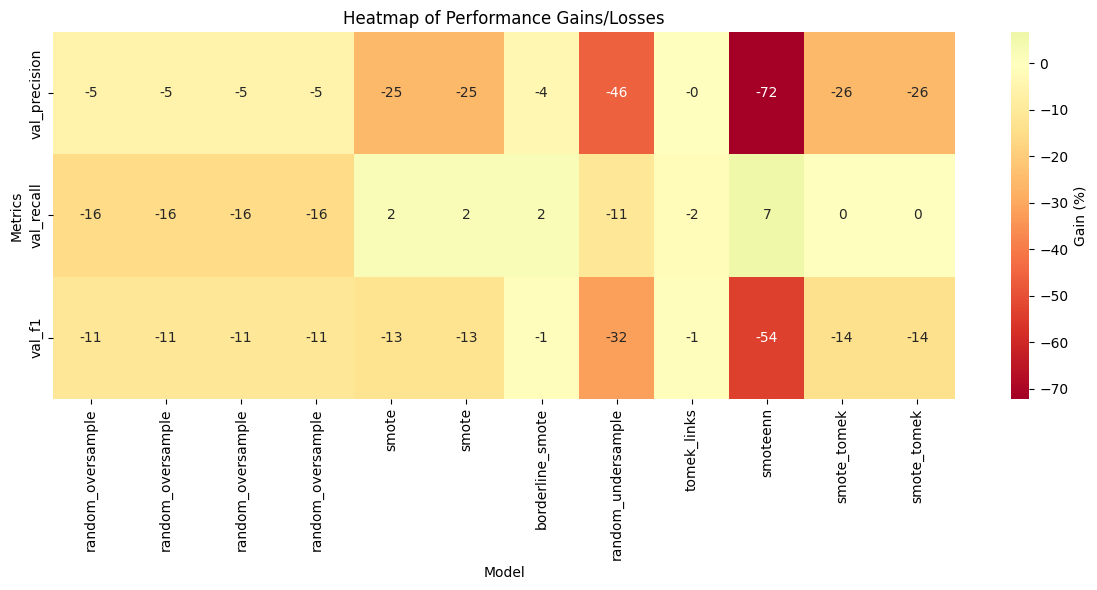

In [197]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_gains_heatmap(df_gains, figsize=(12, 6), cmap="RdYlGn", center=0):
    """
    Plot a heatmap of gains/losses for each metric across different models.
    
    Args:
        df_gains (pd.DataFrame): DataFrame from `calculate_gains()` with columns
                                 ["Model", "f1", "precision", "recall", "pr_auc", 
                                  "g_mean", "training_time"].
        figsize (tuple): Figure size, e.g., (width, height).
        cmap (str): Matplotlib/Seaborn colormap.
        center (float): The value at which to center the colormap. Setting it to 0 
                        helps to visualize negative vs. positive gains.
    """
    # Make sure the first column is "Model" and the rest are numeric metrics
    # Transpose so that metrics are rows (index) and Models are columns
    heatmap_data = df_gains.set_index("samplingMethod").T
    
    # Create the figure and plot the heatmap
    plt.figure(figsize=figsize)
    ax = sns.heatmap(
        heatmap_data, 
        cmap=cmap, 
        center=center, 
        annot=True, 
        fmt=".0f",
        cbar_kws={"label": "Gain (%)"}
    )
    ax.set_ylabel("Metrics")
    ax.set_xlabel("Model")
    ax.set_title("Heatmap of Performance Gains/Losses")
    
    plt.tight_layout()
    plt.show()

plot_gains_heatmap(combined_gain_results[['samplingMethod', 'val_precision', 'val_recall', 'val_f1']])

## Measuring Generalizability

In [198]:
def convert_sampling_method_name(name):
        """
        Converts sampling method names to the required format, except for specific cases.
        """
        if name in {"adasyn", "smote", "smoteenn", "nearmiss"}:
            return name
        return re.sub(r'([a-z])([A-Z])', r'\1_\2', name).lower()
    
def evaluate_sampling_methods(generalizable_results, X_test, y_test):
    """
    Retrains models for each sampling method using the hyperparameters in the DataFrames,
    evaluates them on the test set, and appends new metrics as columns in each DataFrame.
    
    Args:
        generalizable_results (dict): Dictionary where keys are sampling method names,
            and values are DataFrames containing hyperparameter configurations.
        X_test (np.ndarray or pd.DataFrame): Test set features.
        y_test (np.ndarray or pd.Series): Test set labels.
    
    Returns:
        dict: Updated dictionary with DataFrames now containing additional test metrics.
    """
    updated_results = {}
    
    for method, df in generalizable_results.items():
        df = df.copy()  # Prevent modifying original DataFrame
        new_metrics = {
            "test_f1": [], "test_precision": [], "test_recall": [], "test_pr_auc": [], "test_g_mean": []
        }
        
        for _, row in df.iterrows():
            # Extract hyperparameters (handle missing columns safely)
            hyperparams = {param: row[param] for param in [
                "max_depth", "learning_rate", "n_estimators", "subsample",
                "colsample_bytree", "reg_alpha", "reg_lambda", "gamma",
                "min_child_weight", "scale_pos_weight"
            ] if param in row and pd.notna(row[param])}
            
            # Convert sampling method name where necessary
            formatted_sampling_method = row["samplingMethod"]           #convert_sampling_method_name(row["samplingMethod"])
            
            # Train model
            pipeline = FraudDetectionPipeline(sampling_method=formatted_sampling_method)
            pipeline.train_with_cv(X_train, y_train, [hyperparams])
            test_metrics = pipeline.evaluate(X_test, y_test)
            
            # Store test metrics
            new_metrics["test_f1"].append(test_metrics["f1"])
            new_metrics["test_precision"].append(test_metrics["precision"])
            new_metrics["test_recall"].append(test_metrics["recall"])
            new_metrics["test_pr_auc"].append(test_metrics["pr_auc"])
            new_metrics["test_g_mean"].append(test_metrics["g_mean"])
        
        # Add new columns to DataFrame
        for metric_name, metric_values in new_metrics.items():
            df[metric_name] = metric_values
        
        updated_results[method] = df
    
    return updated_results

In [199]:
generalizable_results['smote']

,samplingMethod,max_depth,learning_rate,n_estimators,subsample,colsample_bytree,reg_alpha,reg_lambda,gamma,min_child_weight,...,val_precision,val_recall,val_pr_auc,val_g_mean,diff_f1,diff_precision,diff_recall,diff_pr_auc,diff_g_mean,score
0,smote,6,0.1,100,0.8,0.8,2,100,2,2,...,0.730159,0.867925,0.813952,0.931344,0.018103,0.020777,0.01393,0.037949,0.007484,0.813952
1,smote,6,0.1,200,0.8,0.8,2,100,2,2,...,0.730159,0.867925,0.813952,0.931344,0.018103,0.020777,0.01393,0.037949,0.007484,0.813952


In [ ]:
results_testSet = evaluate_sampling_methods(generalizable_results, X_test, y_test)

In [201]:
def compute_validation_test_diff(Dict_results_test):
    """
    Computes the difference between validation and test metrics for each sampling method.
    
    Args:
        D (dict): Dictionary where keys are sampling methods and values are DataFrames
                  containing validation and test metrics.
    
    Returns:
        dict: Updated dictionary with DataFrames now containing diff2_metric columns.
    """
    for method, df in Dict_results_test.items():
        if df.empty:
            continue
        
        for metric in ["f1", "precision", "recall", "g_mean", "pr_auc"]:
            val_col = f"val_{metric}"
            test_col = f"test_{metric}"
            diff_col = f"diff2_{metric}"
            
            if val_col in df.columns and test_col in df.columns:
                df[diff_col] = df[val_col] - df[test_col]
    
    return Dict_results_test

In [202]:
results_diffBetween_test_val = compute_validation_test_diff(results_testSet)

In [203]:
results_diffBetween_test_val['smoteenn']

,samplingMethod,reg_lambda,n_estimators,val_f1,val_precision,val_recall,val_pr_auc,val_g_mean,diff_f1,diff_precision,...,test_f1,test_precision,test_recall,test_pr_auc,test_g_mean,diff2_f1,diff2_precision,diff2_recall,diff2_g_mean,diff2_pr_auc
0,smoteenn,10,100,0.419214,0.272727,0.90566,0.815475,0.949499,0.024656,0.024333,...,0.424,0.278947,0.883333,0.725027,0.937573,-0.004786,-0.00622,0.022327,0.011925,0.090447


In [204]:
def filter_large_diff2(D, threshold, metric_names):
    """
    Filters out rows where any absolute diff2_metric exceeds the given threshold.
    Removes keys with empty DataFrames after filtering.
    
    Args:
        D (dict): Dictionary of {sampling_method: DataFrame} with diff2_metric columns
        threshold (float): Threshold for absolute difference values
        metric_names (list): List of base metric names (e.g., ['recall', 'precision'])
    
    Returns:
        dict: Filtered dictionary with rows where all absolute diffs <= threshold
    """
    filtered_dict = {}
    
    for method, df in D.items():
        if df.empty:
            continue
        
        # Start with all rows included
        mask = pd.Series(True, index=df.index)
        
        # Apply absolute value check for each metric
        for metric in metric_names:
            diff2_col = f"diff2_{metric}"
            if diff2_col in df.columns:
                mask &= (df[diff2_col].abs() <= threshold)
        
        # Apply the combined mask
        filtered_df = df[mask].copy()
        
        # Only keep non-empty results
        if not filtered_df.empty:
            filtered_dict[method] = filtered_df
    
    return filtered_dict

In [205]:
generalizable_results = filter_large_diff2(results_diffBetween_test_val, 0.07, ['pr_auc'])

In [213]:
generalizable_results['borderline_smote']

,samplingMethod,reg_lambda,val_f1,val_precision,val_recall,val_pr_auc,val_g_mean,diff_f1,diff_precision,diff_recall,...,test_f1,test_precision,test_recall,test_pr_auc,test_g_mean,diff2_f1,diff2_precision,diff2_recall,diff2_g_mean,diff2_pr_auc
0,borderline_smote,1.2,0.901961,0.938776,0.867925,0.88755,0.931575,0.033477,0.037272,0.030147,...,0.818182,0.9,0.75,0.852948,0.865949,0.083779,0.038776,0.117925,0.065626,0.034601


In [887]:
###############################################
###############################################
##############################################
#################################################
##################################################

In [ ]:
def get_all_baselines(model_names, X_train, y_train, X_val, y_val):
    """
    Evaluate multiple baseline models and return results in standardized format.
    
    Args:
        model_names (list): e.g., ["XGB", "RF", "Ada"]
        X_train, y_train: Training data
        X_val, y_val: Validation data
    
    Returns:
        dict: {"ModelName": (metrics, y_pred_proba, y_pred, training_time)}
    """
    results = {}
    models = {}
    for name in model_names:
        try:
            baseline = BaselineModels(name)
            models[name] = baseline
            output = baseline.run(X_train, y_train, X_val, y_val)
            results[name] = output
        except Exception as e:
            print(f"Failed to evaluate {name}: {str(e)}")
    return results, models

def summarize_results(results_dict):
    """
    Convert the output of `automate_training` into a metrics summary DataFrame,
    with all numerical values rounded to 2 decimal places.
    """
    rows = []
    for key, (metrics_dict, _, _, time) in results_dict.items():
        row = {
            'Model_Sampler': key,
            **metrics_dict
            #'training_time': time
        }
        rows.append(row)
    
    df = pd.DataFrame(rows)
    
    # Round all numerical columns to 2 decimals
    numeric_cols = ['f1', 'precision', 'recall', 'pr_auc', 'g_mean']
    df[numeric_cols] = df[numeric_cols].round(3)
    
    # Reorder columns (optional but cleaner)
    column_order = ['Model_Sampler', 'f1', 'precision', 'recall', 'pr_auc', 'g_mean']
    return df[column_order]

# users can choose other baseline models as well e.g. Ada, RandomForest ...
model_names = ["baseline_XGB"]

validation_results_baseline, baseline_models = get_all_baselines(model_names, X_train, y_train, X_validation, y_validation)

validation_baseline = summarize_results(validation_results_baseline)

In [ ]:
def filter_by_metric_diff(results_dict, threshold=0.1):
    """
    Filters the results_dict to include only those entries
    whose metricsDiff values are <= threshold for *all* metrics.

    Parameters:
    results_dict : dict
        Dictionary output by run_experiments, structured as:
            {
              index_0: {
                "configuration": {...},
                "metrics": {...},
                "metricsDiff": {...},
                "score": ...
              },
              index_1: {...},
              ...
            }
    threshold : float, optional
        The maximum allowable difference (default 0.05).
        Meaning that for each entry, *all* metricsDiff values must
        be <= threshold to be included in the filtered results.

    Returns:
    dict
        A subset of results_dict with the same structure,
        but including only those entries that meet the threshold criteria.
    """

    filtered_results = {}

    for idx, entry in results_dict.items():
        # entry["metricsDiff"] is a dict of {metric_name: diff_value}
        diffs = entry["metricsDiff"]

        # Check if all diffs are within the threshold
        if all(d <= threshold for d in diffs.values()):
            # Keep the entire entry (config, metrics, metricsDiff, score)
            filtered_results[idx] = entry

    return filtered_results
    
filtered_results_randomUndersample = filter_by_metric_diff(results_randomUndersample, threshold=0.1)

In [314]:
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from imblearn.pipeline import Pipeline
from sklearn.metrics import classification_report 
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.combine import SMOTEENN
from imblearn.combine import SMOTETomek
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
import time

class FraudDetectionPipeline:
    def __init__(self, sampling_method, model_name, scoring, random_state=42):
        """
        Initialize the pipeline with the specified sampling method and model name.
        
        Parameters:
        - sampling_method: Name of the sampling method (e.g., 'smote', 'adasyn').
        - model_name: Name of the model (e.g., 'XGBoost', 'LightGBM').
        - random_state: Random seed for reproducibility.
        """
        self.sampling_method = sampling_method
        self.model_name = model_name
        self.random_state = random_state
        self.pipeline = None
        self.best_model = None
        self.best_params = None
        self.best_score = None
        self.scoring = None

    def _get_sampler(self):
        """
        Return the appropriate sampler based on the sampling method.
        """
        SAMPLERS = {
            'smote': SMOTE(random_state=self.random_state),
            'adasyn': ADASYN(random_state=self.random_state),
            'random_oversample': RandomOverSampler(random_state=self.random_state),
            'random_undersample': RandomUnderSampler(random_state=self.random_state),
            'tomek_links': TomekLinks(),
            'smoteenn': SMOTEENN(random_state=self.random_state),
            'smote_tomek': SMOTETomek(random_state=self.random_state)
        }
        if self.sampling_method in SAMPLERS:
            return SAMPLERS[self.sampling_method]
        else:
            raise ValueError(f"Unsupported sampling method: {self.sampling_method}")

    def create_pipeline(self, model):
        """
        Create a pipeline with the specified sampling method and model.
        """
        sampler = self._get_sampler()
        self.pipeline = Pipeline([
            ('sampler', sampler),
            ('model', model)
        ])

    def train(self, X_train, y_train, param_grid, cv=3):
        """
        Train the model using GridSearchCV.
        """
        cv_stratified = StratifiedKFold(n_splits=cv, shuffle=True, random_state=self.random_state)
        grid_search = GridSearchCV(
            self.pipeline,
            param_grid,
            cv=cv_stratified,
            scoring=self.scoring,  # Use PR-AUC as the scoring metric
            n_jobs=-1,
            verbose=1
        )
    
        grid_search.fit(X_train, y_train)
        
        self.best_model = grid_search.best_estimator_
        self.best_params = grid_search.best_params_
        self.best_score = grid_search.best_score_

        print(f"Best parameters found for {self.model_name} with {self.sampling_method}: ", self.best_params)
        print(f"Best PR-AUC score for {self.model_name} with {self.sampling_method}: ", self.best_score)

    def evaluate(self, X_test, y_test):
        """
        Evaluate the best model on the test set and return metrics and probabilities.
        
        Returns:
        - results: Dictionary of metrics.
        - y_pred_proba: Predicted probabilities.
        """
        if self.best_model is None:
            raise ValueError("Model has not been trained yet. Call `train()` first.")

        y_pred = self.best_model.predict(X_test)
        y_pred_proba = self.best_model.predict_proba(X_test)[:, 1]

        # Compute metrics
        results = self.compute_metrics(y_test, y_pred, y_pred_proba)

        print(f"Metrics for {self.model_name} with {self.sampling_method}:")
        print(results)
        print("Classification Report:")
        print(classification_report(y_test, y_pred))

        return results, y_pred_proba, y_pred

    def evaluate_quietly(self, X_test, y_test):
        """
        Evaluate the best model on the test set and return metrics and probabilities, 
        without the printing involved in the evaluate method.
        
        Returns:
        - results: Dictionary of metrics.
        - y_pred_proba: Predicted probabilities.
        """
        if self.best_model is None:
            raise ValueError("Model has not been trained yet. Call `train()` first.")

        y_pred = self.best_model.predict(X_test)
        y_pred_proba = self.best_model.predict_proba(X_test)[:, 1]

        # Compute metrics
        results = self.compute_metrics(y_test, y_pred, y_pred_proba)

        return results, y_pred_proba, y_pred

    @staticmethod
    def compute_metrics(y_true, y_pred, y_pred_proba):
        """
        Compute evaluation metrics.
        """
        metrics = {}
        metrics['f1'] = f1_score(y_true, y_pred)
        metrics['precision'] = precision_score(y_true, y_pred)
        metrics['recall'] = recall_score(y_true, y_pred)
        metrics['pr_auc'] = average_precision_score(y_true, y_pred_proba)
        metrics['g_mean'] = FraudDetectionPipeline.calculate_g_mean(y_true, y_pred)
        return metrics

    @staticmethod
    def calculate_g_mean(y_true, y_pred):
        """
        Calculate geometric mean of sensitivity and specificity.
        """
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        specificity = tn / (tn + fp)
        recall = tp / (tp + fn)
        g_mean = np.sqrt(recall * specificity)
        return g_mean

In [315]:
def create_train_evaluate_pipeline(
    model_name, 
    sampling_method,
    parameters_grid=None,
    model= None,
    X_train=X_train, 
    y_train=y_train, 
    X_test=X_validation, # default evaluation on the validation set. Can be changed to alternative valid choices, e.g. X_test 
    y_test=y_validation,  
    scoring='average_precision',
    random_state=42):
    """
    Generalize the creation, training, and evaluation of a FraudDetectionPipeline.
    """
    # Define shared arguments
    pipeline_args = {
        'model_name': model_name,
        'sampling_method': sampling_method,
        'scoring': scoring,
        'random_state': random_state
    }
    
    # Initialize the pipeline with unpacked arguments
    pipeline = FraudDetectionPipeline(**pipeline_args)
    
    # Record start time
    start_time = time.time()
    
    # Create pipeline and train
    pipeline.create_pipeline(model)  # Adjust if using a different model
    pipeline.train(X_train, y_train, parameters_grid, cv=5)

    best_estimator = pipeline.best_model
    
    # Record end time and calculate duration
    end_time = time.time()
    create_train_time = end_time - start_time
    
    print(f"Time taken for creating and training the {model_name} pipeline with {sampling_method}: {create_train_time:.2f} seconds")
    
    # Evaluate the pipeline
    metrics, y_pred_proba, y_pred = pipeline.evaluate(X_test, y_test)
    
    # Dynamically name the create_train_time variable
    #globals()[f"create_train_time_{model_name}_{sampling_method}"] = create_train_time
    
    return best_estimator, metrics, y_pred_proba, y_pred, create_train_time

In [328]:
XGB_smote_related = {
        'model__max_depth': [7],
        'model__learning_rate': [0.1],
        'model__n_estimators': [200],
        'model__subsample': [0.8],
        'model__colsample_bytree': [0.8],

        # Added regularization/anti-overfitting parameters
        'model__reg_alpha': [1],      # L1 regularization
        'model__reg_lambda': [100],       # L2 regularization
        'model__gamma': [2],          # Min split loss
        'model__min_child_weight': [4],      # Conservative splits
        'model__scale_pos_weight': [0.15]     # Adjust for class imbalance
    }

ada_param_grid = {}

rf_param_grid = {
    'model__n_estimators': [50],
    'model__max_depth': [5, 6],
    'model__min_samples_split': [2],
    'model__min_samples_leaf': [1, 2],
    'model__max_features': [0.8],
}

hyperparam_dict = {
    "Ada_smote": ada_param_grid,
    "Ada_smoteenn": ada_param_grid,
    "Ada_random_undersample": ada_param_grid,
    "Ada_random_oversample": ada_param_grid,
    "Ada_tomek_links": ada_param_grid,
    "Ada_adasyn": ada_param_grid,
    "RF_smote": {
        'model__n_estimators': [100],
        'model__max_depth': [4],
        'model__min_samples_split': [2],
        'model__min_samples_leaf': [1],
        'model__max_features': [0.8],
    },
    "RF_smoteenn": {
        'model__n_estimators': [100],
        'model__max_depth': [6],
        'model__min_samples_split': [2],
        'model__min_samples_leaf': [1],
        'model__max_features': [0.7],
    },
    "RF_random_undersample": {
        'model__n_estimators': [200],
        'model__max_depth': [6],
        'model__min_samples_split': [2],
        'model__min_samples_leaf': [1],
        'model__max_features': [0.7],
    },
    "RF_random_oversample": {
        'model__n_estimators': [100],
        'model__max_depth': [6, 7],
        'model__min_samples_split': [2],
        'model__min_samples_leaf': [1],
        'model__max_features': [0.8],
    },
    "RF_tomek_links": {
        'model__n_estimators': [200],
        'model__max_depth': [7],
        'model__min_samples_split': [2],
        'model__min_samples_leaf': [2],
        'model__max_features': [0.8],
    },
    "RF_adasyn": {
        'model__n_estimators': [200],
        'model__max_depth': [5],
        'model__min_samples_split': [1, 2],
        'model__min_samples_leaf': [1, 2],
        'model__max_features': [0.8],
    },
    "XGB_smote": XGB_smote_related,
    "XGB_adasyn": XGB_smote_related,
    "XGB_random_undersample": {
        'model__max_depth': [5],
        'model__learning_rate': [0.1],
        'model__n_estimators': [200],
        'model__subsample': [0.8],
        'model__colsample_bytree': [0.8],

        # Added regularization/anti-overfitting parameters
        'model__reg_alpha': [1],      # L1 regularization
        'model__reg_lambda': [100],       # L2 regularization
        'model__gamma': [2],          # Min split loss
        'model__min_child_weight': [2],      # Conservative splits
        'model__scale_pos_weight': [0.15]     # Adjust for class imbalance
    },
    "XGB_random_oversample": XGB_smote_related,
    "XGB_adasyn": XGB_smote_related,
    "XGB_smote_tomek": XGB_smote_related,
    "XGB_tomek_links": {
        'model__max_depth': [7],
        'model__learning_rate': [0.1],
        'model__n_estimators': [200],
        'model__subsample': [0.8],
        'model__colsample_bytree': [0.8],

        # Added regularization/anti-overfitting parameters
        'model__reg_alpha': [1],      # L1 regularization
        'model__reg_lambda': [100],       # L2 regularization
        'model__gamma': [2],          # Min split loss
        'model__min_child_weight': [4],      # Conservative splits
        'model__scale_pos_weight': [1]     # Adjust for class imbalance
    },
    "XGB_smoteenn": XGB_smote_related
}

In [329]:
def automate_training(Dict={}, 
                      modelNames=["RF", "XGB", "Ada"], 
                      sampleMethods=["random_undersample", "smote", "random_oversample", "adasyn", "smoteenn", "tomek_links", "smote_tomek"], 
                      X=X_validation, 
                      y=y_validation,
                      scoring='average_precision'):
    """
    Fixed version with proper scoping and error handling.
    """

    base_model = DecisionTreeClassifier(max_depth=9)  # Correct class name is DecisionTreeClassifier

    model_dict = {
        "XGB": XGBClassifier(eval_metric='logloss', random_state=42),
        "Ada": AdaBoostClassifier(estimator=base_model, random_state=42, n_estimators=100),
        "RF": RandomForestClassifier(random_state=42)
    }
    results = {}
    best_models = {}

    for model_name in modelNames:
        for sampler in sampleMethods:
            key = f"{model_name}_{sampler}"
            
            if key not in Dict:
                warnings.warn(f"Missing grid: {key}", UserWarning)
                continue
                
            try:
                # Clone model to avoid state pollution
                model = model_dict[model_name] 
                params_grid = Dict[key]

                print(f"Training {model_name} with {sampler}...")
                best_model, metrics, y_proba, y_pred, time = create_train_evaluate_pipeline(
                    model_name=model_name,
                    sampling_method=sampler,
                    parameters_grid=params_grid,
                    model=model,
                    X_test=X,
                    y_test=y,
                    scoring=scoring
                )
                
                results[key] = (metrics, y_proba, y_pred, time)
                best_models[key] = best_model

            except Exception as e:
                warnings.warn(f"Failed {key}: {str(e)}")
                continue

    return results, best_models

In [ ]:
validation_results, best_models_trained = automate_training(Dict=hyperparam_dict, 
                                                            modelNames=["XGB"], 
                                                            sampleMethods=["random_undersample", 
                                                                           "smote", 
                                                                           "random_oversample", 
                                                                           "adasyn", "smoteenn", 
                                                                           "tomek_links",
                                                                           "smote_tomek"])

In [320]:
validation_dataframe = summarize_results(validation_results)

validation_dataframe

,Model_Sampler,f1,precision,recall,pr_auc,g_mean,training_time
0,RF_random_undersample,0.081,0.042,0.962,0.814,0.960,2.610
1,RF_smote,0.205,0.116,0.925,0.779,0.955,579.061
2,RF_random_oversample,0.470,0.320,0.887,0.799,0.940,588.029
3,RF_adasyn,0.176,0.098,0.906,0.776,0.944,1509.922
4,RF_smoteenn,0.242,0.140,0.887,0.807,0.937,1149.091
5,RF_tomek_links,0.878,0.956,0.811,0.879,0.901,1085.234
6,XGB_random_undersample,0.084,0.044,0.943,0.814,0.952,37.081
7,XGB_smote,0.821,0.780,0.868,0.881,0.931,8.796
8,XGB_random_oversample,0.909,0.978,0.849,0.907,0.921,1248.866
9,XGB_adasyn,0.882,0.918,0.849,0.902,0.921,1433.291


In [93]:
def transform_model_sampler(df):
    def process_name(name):
        # Split into model and sampling parts
        parts = name.split('_', 1)
        if len(parts) == 1:
            return name  # Return unchanged if no sampling method
        
        model, sampler = parts
        # Split sampler components and capitalize subsequent parts
        sampler_parts = sampler.split('_')
        processed_sampler = sampler_parts[0] + ''.join([p.capitalize() for p in sampler_parts[1:]])
        
        return f"{model}_{processed_sampler}"
    
    # Apply the transformation to the Model_Sampler column
    df['Model_Sampler'] = df['Model_Sampler'].apply(process_name)
    return df

In [94]:
validation_df = transform_model_sampler(validation_dataframe)

In [95]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def calculate_gains(DF1_baseline, DF2_tuned):
    """
    Calculate performance gains of tuned models (DF2) over baselines (DF1).
    
    Args:
        DF1_baseline (pd.DataFrame): Baseline results (columns: Model_Sampler, f1, ..., training_time).
        DF2_tuned (pd.DataFrame): Tuned results (columns: Model_Sampler, f1, ..., training_time).
    
    Returns:
        pd.DataFrame: Gains DataFrame with same structure as DF2_tuned but values as % gains.
    """
    # Copy to avoid modifying original DataFrames
    df_baseline = DF1_baseline.copy()
    df_tuned = DF2_tuned.copy()
    
    # Prepare baseline DataFrame (Model_Sampler → Model)
    df_baseline["Model"] = df_baseline["Model_Sampler"]
    df_baseline = df_baseline.set_index("Model")
    
    # Prepare tuned DataFrame (split Model_Sampler into Model and Sampler)
    df_tuned[["Model", "Sampler"]] = df_tuned["Model_Sampler"].str.split("_", expand=True)
    
    # Merge to align tuned models with their baselines
    merged = df_tuned.merge(
        df_baseline,
        on="Model",
        suffixes=("_tuned", "_baseline")
    )
    
    # Calculate gains for metrics (higher is better)
    metrics = ['f1', 'precision', 'recall', 'pr_auc', 'g_mean']
    for metric in metrics:
        merged[f"{metric}_gain"] = (
            (merged[f"{metric}_tuned"] / merged[f"{metric}_baseline"] - 1) * 100
        ).round(2)
    
    # Calculate gain for training time (lower is better)
    merged["training_time_gain"] = (
        (merged["training_time_baseline"] / merged["training_time_tuned"] - 1) * 100
    ).round(2)
    
    # Create final gains DataFrame
    gain_cols = [f"{metric}_gain" for metric in metrics] + ["training_time_gain"]
    df_gains = merged[["Model"] + gain_cols].copy()
    df_gains.columns = ["Model"] + metrics + ["training_time"]
    df_gains["Model"] = df_tuned["Model_Sampler"]
    
    return df_gains

In [102]:
gains = calculate_gains(baseline_summary, validation_df)

gains

,Model,f1,precision,recall,pr_auc,g_mean,training_time
0,RF_randomUndersample,-90.98,-95.71,15.90,-7.60,5.38,4854.75
1,RF_smote,-77.17,-88.14,11.45,-11.58,4.83,-77.67
2,RF_randomOversample,-47.66,-67.28,6.87,-9.31,3.18,-78.01
3,RF_adasyn,-80.40,-89.98,9.16,-11.92,3.62,-91.44
4,RF_smoteenn,-73.05,-85.69,6.87,-8.40,2.85,-88.75
5,RF_tomekLinks,-2.23,-2.25,-2.29,-0.23,-1.10,-88.08
6,XGB_randomUndersample,-90.76,-95.50,11.07,-9.66,3.37,-98.26
7,XGB_smote,-9.68,-20.25,2.24,-2.22,1.09,-92.64
8,XGB_randomOversample,0.00,0.00,0.00,0.67,0.00,-99.95
9,XGB_adasyn,-2.97,-6.13,0.00,0.11,0.00,-99.95


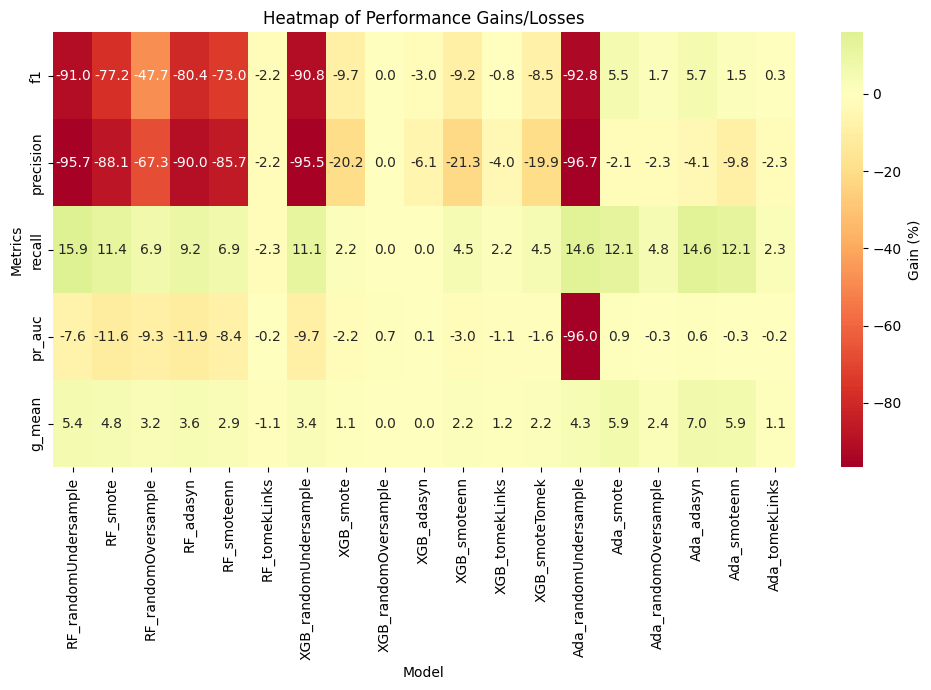

In [105]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_gains_heatmap(df_gains, figsize=(10, 7), cmap="RdYlGn", center=0):
    """
    Plot a heatmap of gains/losses for each metric across different models.
    
    Args:
        df_gains (pd.DataFrame): DataFrame from `calculate_gains()` with columns
                                 ["Model", "f1", "precision", "recall", "pr_auc", 
                                  "g_mean", "training_time"].
        figsize (tuple): Figure size, e.g., (width, height).
        cmap (str): Matplotlib/Seaborn colormap.
        center (float): The value at which to center the colormap. Setting it to 0 
                        helps to visualize negative vs. positive gains.
    """
    # Make sure the first column is "Model" and the rest are numeric metrics
    # Transpose so that metrics are rows (index) and Models are columns
    heatmap_data = df_gains.set_index("Model").T
    
    # Create the figure and plot the heatmap
    plt.figure(figsize=figsize)
    ax = sns.heatmap(
        heatmap_data, 
        cmap=cmap, 
        center=center, 
        annot=True, 
        fmt=".1f",
        cbar_kws={"label": "Gain (%)"}
    )
    
    ax.set_ylabel("Metrics")
    ax.set_xlabel("Model")
    ax.set_title("Heatmap of Performance Gains/Losses")
    
    plt.tight_layout()
    plt.show()

plot_gains_heatmap(gains.drop(columns="training_time"))

In [106]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, roc_curve, auc

class FraudDetectionVisualizer:
    def __init__(self, y_true, results_dict):
        """
        Initialize the visualizer with:
        
        - y_true: Ground truth labels (1D array-like).
        - results_dict: A dictionary where each key is a string 
          "modelName_samplingMethod", and each value is a tuple of:
              (metrics_dict, predicted_proba_array)
        The 'metrics_dict' can contain various metrics like 'accuracy', 'f1', etc.
        The 'predicted_proba_array' are the predicted probabilities for the positive class.
        """
        self.y_true = y_true
        self.results_dict = results_dict

    def plot_precision_recall_curve(self):
        """
        Plot the Precision-Recall Curve for all entries in the results dictionary.
        """
        plt.figure(figsize=(10, 6))
        #(metrics, y_pred_proba, y_pred, training_time)
        for label, (metrics, y_pred_proba, _, _) in self.results_dict.items():
            precision, recall, _ = precision_recall_curve(self.y_true, y_pred_proba)
            # 'label' here is something like "XGBoost_SMOTE"
            plt.plot(recall, precision, label=label)

        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.legend(loc='lower left', fontsize='small')
        plt.grid(True)
        plt.show()

    def plot_precision_recall_with_threshold(self):
        """
        Plot Precision and Recall vs Threshold for all entries in the results dictionary.
        """
        plt.figure(figsize=(10, 6))

        for label, (metrics, y_pred_proba, _, _) in self.results_dict.items():
            precision, recall, thresholds = precision_recall_curve(self.y_true, y_pred_proba)
            # We'll plot precision and recall separately against threshold:
            plt.plot(thresholds, precision[:-1], label=f'{label} Precision')
            plt.plot(thresholds, recall[:-1], label=f'{label} Recall')

        plt.xlabel('Threshold')
        plt.ylabel('Value')
        plt.title('Precision and Recall vs Threshold')
        plt.legend(loc='best', fontsize='small')
        plt.grid(True)
        plt.show()

    def plot_roc_curve(self):
        """
        Plot the ROC Curve for all entries in the results dictionary.
        """
        plt.figure(figsize=(10, 6))

        for label, (metrics, y_pred_proba, _, _) in self.results_dict.items():
            fpr, tpr, _ = roc_curve(self.y_true, y_pred_proba)
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})')

        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend(loc='lower right', fontsize='small')
        plt.grid(True)
        plt.show()

    def plot_auc_curve(self):
        """
        Plot the ROC AUC as a bar chart for all entries in the results dictionary.
        """
        auc_values = {}
        for label, (metrics, y_pred_proba, _, _) in self.results_dict.items():
            fpr, tpr, _ = roc_curve(self.y_true, y_pred_proba)
            auc_values[label] = auc(fpr, tpr)

        plt.figure(figsize=(10, 6))
        plt.bar(auc_values.keys(), auc_values.values(), color='skyblue')
        plt.xlabel('Model and Sampling Method')
        plt.ylabel('AUC')
        plt.title('AUC Scores')
        plt.xticks(rotation=45, ha='right', fontsize='small')
        plt.grid(axis='y')
        plt.show()

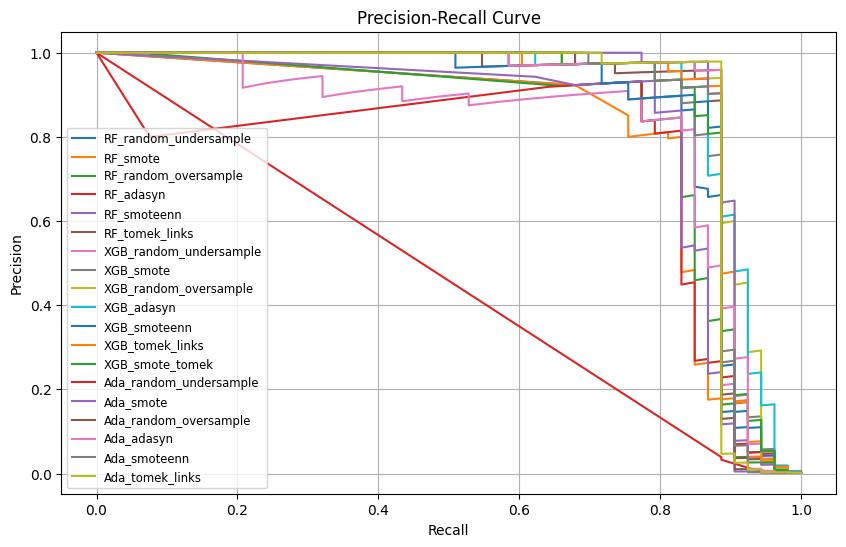

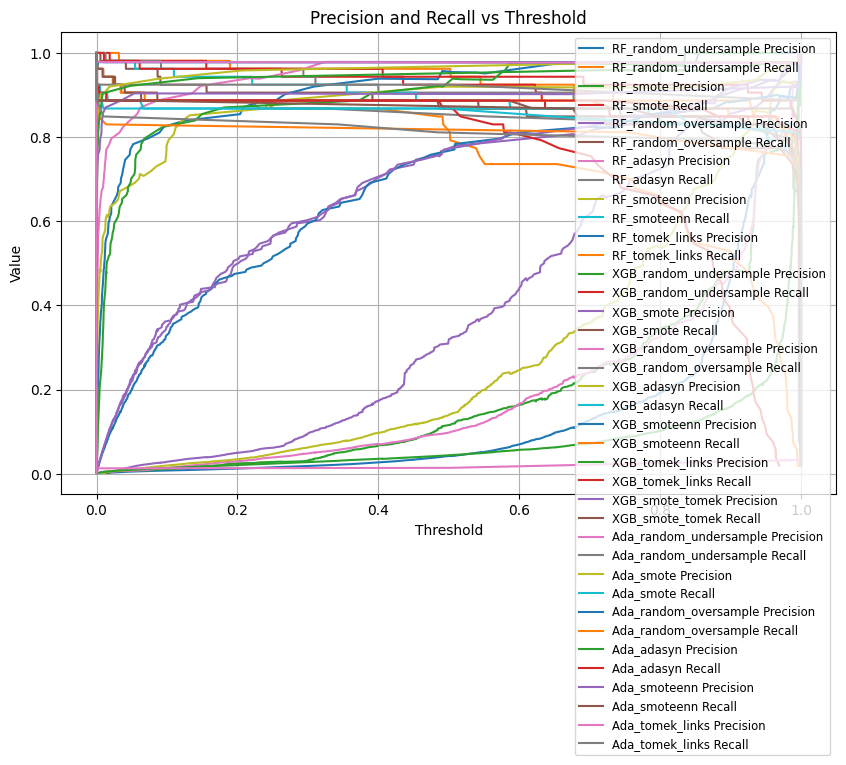

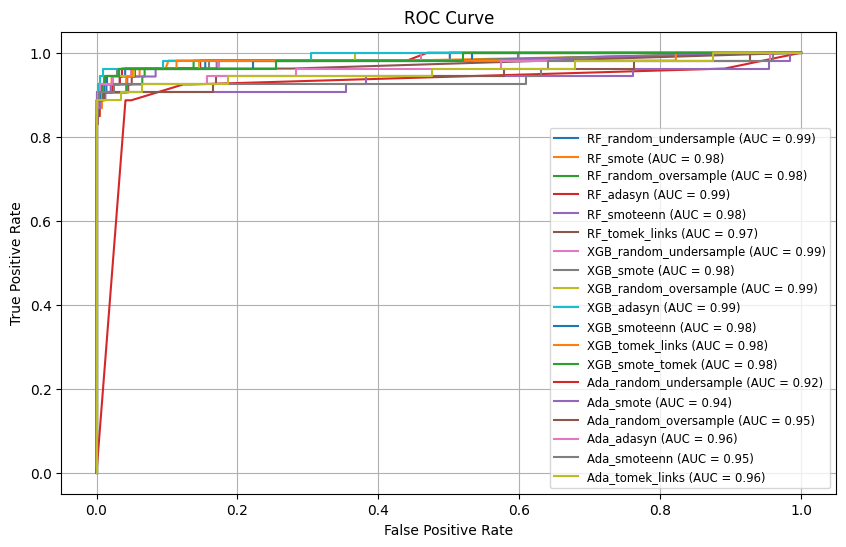

In [107]:
visualizer = FraudDetectionVisualizer(y_validation, validation_results)

visualizer.plot_precision_recall_curve()
visualizer.plot_precision_recall_with_threshold()
visualizer.plot_roc_curve()

In [108]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

class ErrorVisualizer:
    def __init__(self, y_true, results_dict):
        """
        Initialize the visualizer with:
        
        - y_true: Ground truth labels (1D array-like)
        - results_dict: Dictionary where keys are "modelName_samplingMethod",
          and values are tuples of (metrics_dict, predicted_labels_array)
        """
        self.y_true = y_true
        self.results_dict = results_dict

    def _create_subplots(self, num_plots):
        """Helper to create subplots grid with 6 plots per row"""
        rows = (num_plots + 5) // 6  # Calculate needed rows
        fig, axes = plt.subplots(rows, 6, figsize=(36, 5 * rows))
        return fig, axes.flatten()

    def plot_confusion_heatmap_per_model(self):
        """Plot individual confusion matrix for each model"""
        for label, (_, _, y_pred, _) in self.results_dict.items():
            cm = confusion_matrix(self.y_true, y_pred)
            plt.figure(figsize=(6, 5))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                        xticklabels=["Non-Fraud", "Fraud"], 
                        yticklabels=["Non-Fraud", "Fraud"])
            plt.xlabel("Predicted")
            plt.ylabel("Actual")
            plt.title(f"Confusion Matrix: {label}")
            plt.show()

    def plot_combined_confusion_heatmap_log(self):
        """Combined log-scaled heatmaps with 6 per row"""
        num_models = len(self.results_dict)
        fig, axes = self._create_subplots(num_models)
        
        for i, (label, (_, _, y_pred, _)) in enumerate(self.results_dict.items()):
            cm = confusion_matrix(self.y_true, y_pred)
            log_cm = np.log1p(cm)  # Log transformation
            sns.heatmap(log_cm, annot=True, fmt='.2f', cmap='Blues', cbar=False,
                        xticklabels=["Non-Fraud", "Fraud"], 
                        yticklabels=["Non-Fraud", "Fraud"], ax=axes[i])
            axes[i].set_title(f"Log {label}")
            axes[i].set_xlabel("Predicted")
            axes[i].set_ylabel("Actual")

        # Turn off empty subplots
        for j in range(i + 1, len(axes)):
            axes[j].axis('off')
            
        plt.tight_layout()
        plt.show()

    def plot_combined_confusion_heatmap(self):
        """Combined heatmaps with 6 per row"""
        num_models = len(self.results_dict)
        fig, axes = self._create_subplots(num_models)
        
        for i, (label, (_, _, y_pred, _)) in enumerate(self.results_dict.items()):
            cm = confusion_matrix(self.y_true, y_pred)
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                        xticklabels=["Non-Fraud", "Fraud"], 
                        yticklabels=["Non-Fraud", "Fraud"], ax=axes[i])
            axes[i].set_title(label)
            axes[i].set_xlabel("Predicted")
            axes[i].set_ylabel("Actual")

        # Turn off empty subplots
        for j in range(i + 1, len(axes)):
            axes[j].axis('off')
            
        plt.tight_layout()
        plt.show()

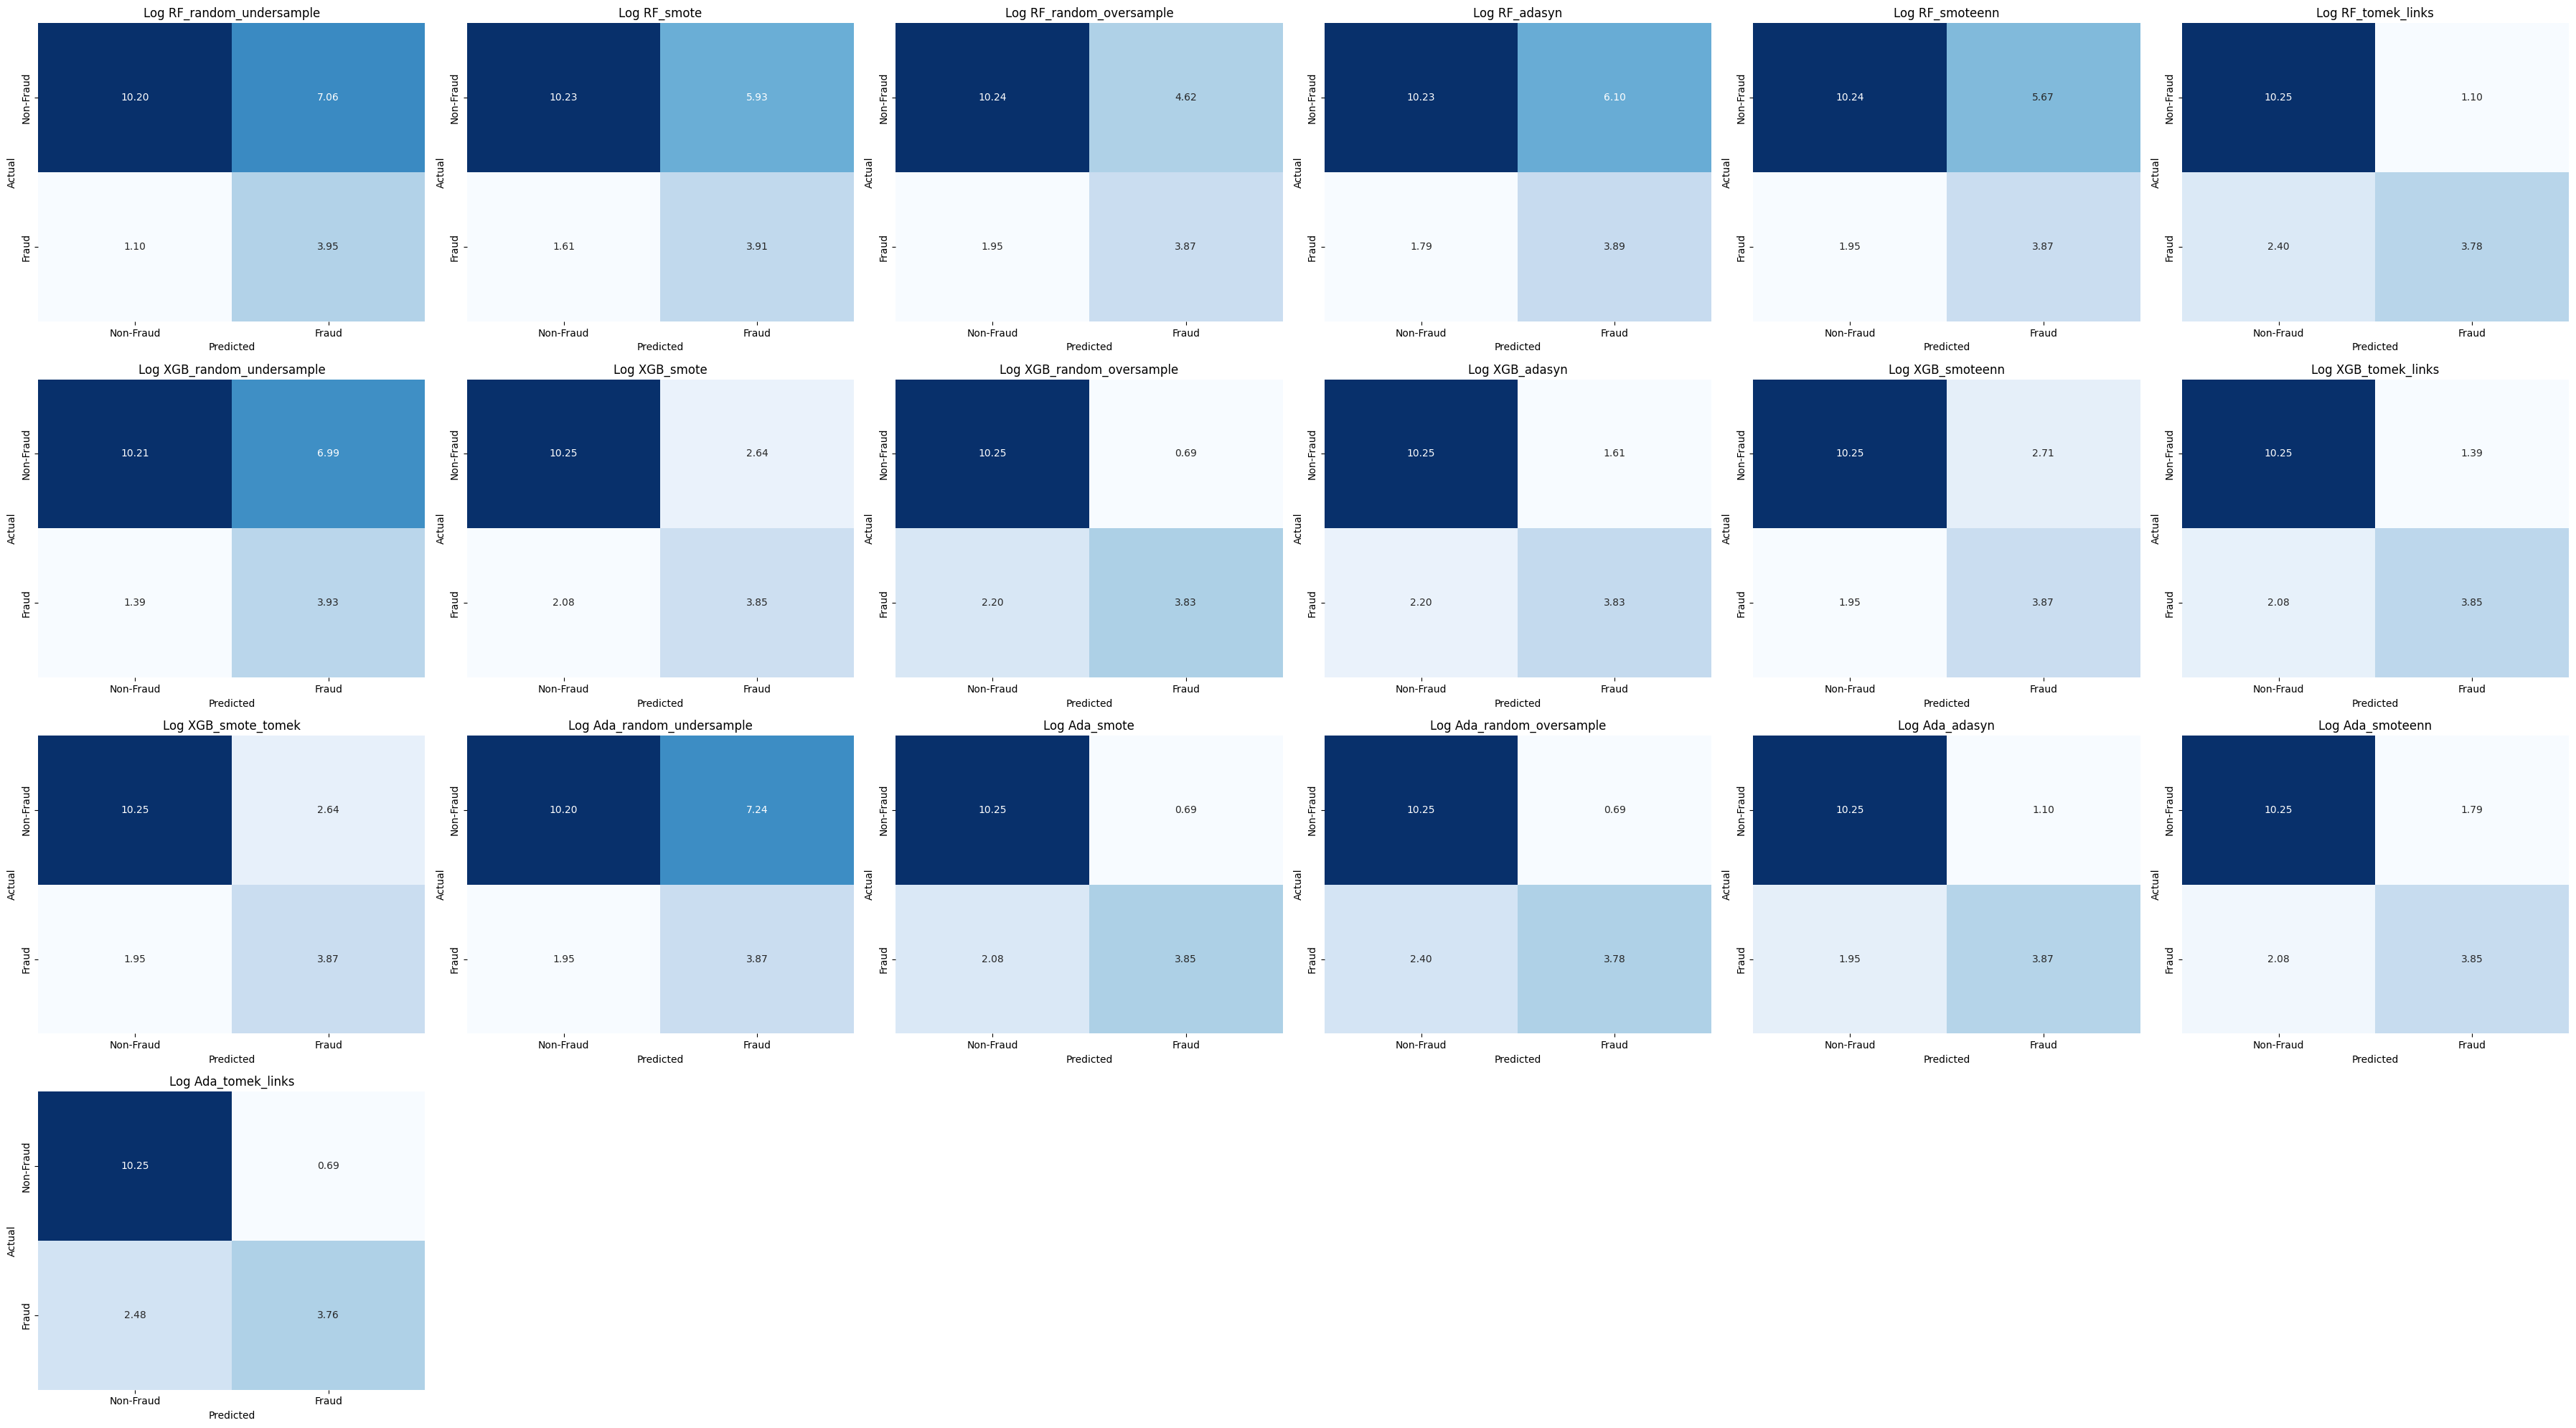

In [109]:
visualizer = ErrorVisualizer(y_validation, validation_results)

# Plot individual confusion heatmaps for each model
##visualizer.plot_confusion_heatmap_per_model()

# Plot combined heatmaps for all models in one figure
visualizer.plot_combined_confusion_heatmap_log()

In [110]:
import matplotlib.pyplot as plt
import math

def plot_train_val_test_curves(D, metric_name="recall"):
    """
    Plots a train-validation-test 'curve' for each model across different sampling methods.

    Parameters
    ----------
    D : dict
        A dictionary with keys 'train_results', 'validation_results', 'test_results'.
        Each value is itself a dict. The sub-dicts all share the same set of keys 
        in the form "ModelName_SamplingMethod". Example:

    metric_name : str, optional (default='accuracy')
        The name of the metric to plot. Must exist in the metrics_dict for 
        train, validation, and test sub-dictionaries.

    Returns
    -------
    None
        Displays one figure per model, where each figure has lines representing
        each sampling method's train–validation–test performance.
    """
    # Safety checks
    required_keys = {"train_results", "validation_results", "test_results"}
    if not required_keys.issubset(D.keys()):
        raise ValueError(f"D must contain at least these keys: {required_keys}")

    # Extract the sub-dictionaries
    train_dict = D["train_results"]
    val_dict   = D["validation_results"]
    test_dict  = D["test_results"]

    # -----------------------------------------------------------
    # 1. Identify all "ModelName_SamplingMethod" keys in train_dict.
    #    We'll parse them to figure out which models exist,
    #    and which sampling methods correspond to each model.
    # -----------------------------------------------------------
    model_to_samplers = {}
    for key in train_dict.keys():
        # Example: key = "XGB_smote" -> model = "XGB", sampler = "smote"
        parts = key.split("_", 1)  # split on the first underscore only
        if len(parts) == 2:
            model, sampler = parts
        else:
            # If there's no underscore, treat the entire key as the model name
            model = parts[0]
            sampler = ""  # no sampling name
        model_to_samplers.setdefault(model, []).append(sampler)

    # -----------------------------------------------------------
    # 2. For each model, produce ONE plot containing lines
    #    for each sampling method. Each line has 3 points:
    #    Train, Validation, Test for the specified metric.
    # -----------------------------------------------------------
    for model, samplers in model_to_samplers.items():
        # Create a new figure for this model
        fig, ax = plt.subplots(figsize=(7, 5))

        for sampler in samplers:
            # Reconstruct the full key
            if sampler:
                full_key = f"{model}_{sampler}"
            else:
                full_key = model  # if no sampling method in the name

            # Retrieve the tuples from each data split
            train_tuple = train_dict.get(full_key)
            val_tuple   = val_dict.get(full_key)
            test_tuple  = test_dict.get(full_key)

            # If this particular model-sampler wasn't found in any of the sub-dicts, skip it
            if train_tuple is None or val_tuple is None or test_tuple is None:
                continue

            # Each tuple is (metrics_dict, y_proba, y_pred, training_time)
            train_metrics = train_tuple[0]
            val_metrics   = val_tuple[0]
            test_metrics  = test_tuple[0]

            # Get the requested metric from each
            train_val = train_metrics.get(metric_name, None)
            val_val   = val_metrics.get(metric_name, None)
            test_val  = test_metrics.get(metric_name, None)

            # If the metric is missing from any of the dictionaries, skip
            if train_val is None or val_val is None or test_val is None:
                continue

            # We'll plot these three points as a "curve" for this sampling method
            x = [0, 1, 2]
            y = [train_val, val_val, test_val]

            ax.plot(x, y, marker='o', label=sampler)

        # Configure x-axis as ["Train", "Validation", "Test"]
        ax.set_xticks([0, 1, 2])
        ax.set_xticklabels(["Train", "Validation", "Test"])

        # Labeling, title, legend
        ax.set_ylabel(metric_name)
        ax.set_title(f"{model} - {metric_name} (Train/Val/Test)")
        ax.legend(title="Sampling Method", loc="best")
        ax.grid(True)

        plt.tight_layout()
        plt.show()

In [113]:
def evaluate_tuned_models(tuned_models_dict, X, y):
    results = {}

    for model_name, model_pipeline in tuned_models_dict.items():
        # Generate predictions
        y_pred = model_pipeline.predict(X)
        y_pred_proba = model_pipeline.predict_proba(X)[:, 1]  # Probability for class 1

        tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
        specificity = tn / (tn + fp)
        recall = tp / (tp + fn)
        g_mean = np.sqrt(recall * specificity)
    
        # Calculate metrics
        metrics = {
            "f1": round(f1_score(y, y_pred), 3),          # Rounded
            "precision": round(precision_score(y, y_pred), 3),  
            "recall": round(recall_score(y, y_pred), 3),
            "pr_auc": round(average_precision_score(y, y_pred_proba), 3),
            "g-mean": round(g_mean, 3)
        }
    
        results[model_name] = (metrics, y_pred_proba, y_pred, 0)
    return results

In [154]:
def wrapper_evaluate_baseline_models(model_dict, X_val, y_val):
    """
    Evaluates a dictionary of trained BaselineModels on the validation set.
    
    Args:
        model_dict (dict): Dictionary where keys are model names and values are trained BaselineModels instances.
        X_val (array-like): Validation feature set.
        y_val (array-like): Validation labels.
    
    Returns:
        dict: Dictionary containing evaluation metrics, predicted probabilities, and predicted labels for each model.
    """
    results = {}

    for model_name, model_instance in model_dict.items():
        if not isinstance(model_instance, BaselineModels):
            raise ValueError(f"Value for key '{model_name}' is not an instance of BaselineModels.")
        
        if model_instance.model is None:
            raise ValueError(f"Model '{model_name}' has not been trained. Train the model before evaluation.")
        
        # Perform evaluation
        model_instance.evaluate(X_val, y_val)

        # Store results
        results[model_name] = (model_instance.metrics,
                               model_instance.y_pred_proba,
                               model_instance.y_pred,
                               0     # dummy put here for compatibility with summarize_results function
                              )
    
    return results

In [155]:
test_results_baseline = wrapper_evaluate_baseline_models(baseline_models, X_test, y_test)
train_results_baseline = wrapper_evaluate_baseline_models(baseline_models, X_train, y_train)

In [193]:
test_baseline = summarize_results(test_results_baseline)
train_baseline = summarize_results(train_results_baseline)

validation_test_results = pd.concat([validation_baseline, test_baseline], axis=0).rename(columns={"Model": "Model_Sampler"})

In [125]:
# Convert results to a DataFrame
test_results = evaluate_tuned_models(best_models_trained, X_test, y_test)

train_results = evaluate_tuned_models(best_models_trained, X_train, y_train)

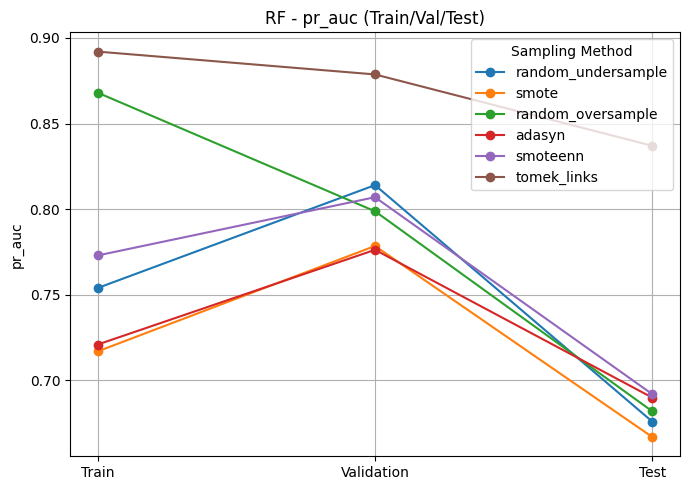

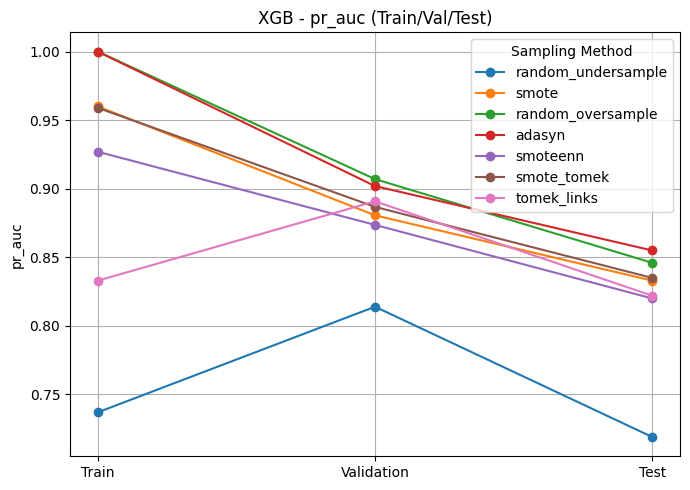

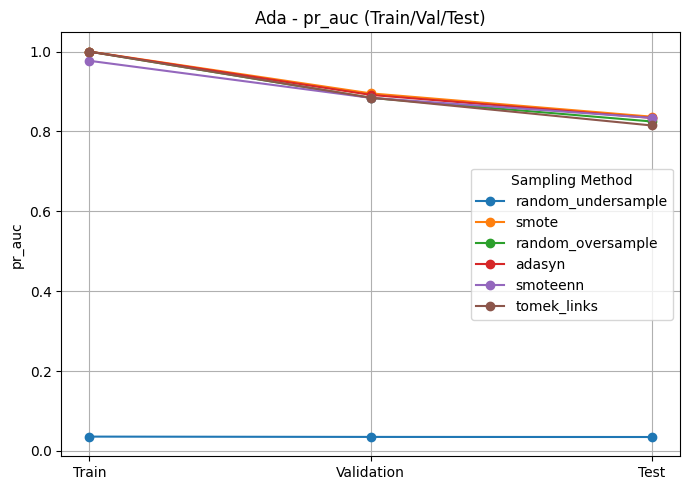

In [128]:
D = {"train_results": train_results,
     "test_results": test_results,
     "validation_results": validation_results
    }


plot_train_val_test_curves(D, metric_name="pr_auc")

In [13]:
import numpy as np
from scipy.stats import entropy
from sklearn.metrics import hamming_loss
from itertools import combinations

class ModelEnsembler:
    def __init__(self, validation_results, metric_name='f1', top_k=2):
        """
        Initialize the ensembler with:
        
        :param validation_results: Dictionary containing model results with:
            Key: "Model_Sampler" string (e.g., "XGB_smote")
            Value: Tuple (metrics_dict, y_proba, y_pred, training_time)
        :param metric_name: Key name for the primary evaluation metric (e.g., 'f1')
        :param top_k: Number of top models to consider per algorithm type
        """
        self.validation_results = validation_results
        self.metric_name = metric_name
        self.top_k = top_k
        self.models = self.group_models_by_algorithm()
        
    def group_models_by_algorithm(self):
        """
        Group models by their base algorithm (e.g. 'XGB', 'RF', 'Ada').

        The part before the first underscore is treated as the algorithm name.
        Everything after is treated as the sampling method (e.g. 'smote').
        """
        algorithms = {}
        for model_key, data in self.validation_results.items():
            # model_key example: "XGB_smote"
            parts = model_key.split('_', 1)
            if len(parts) == 2:
                base_algo, _ = parts
            else:
                base_algo = parts[0]
            if base_algo not in algorithms:
                algorithms[base_algo] = []
            algorithms[base_algo].append((model_key, data))
        return algorithms
    
    def calculate_diversity(self, y_pred1, y_pred2, y_proba1, y_proba2):
        """
        Calculate Hamming-based similarity and a KL-based measure separately.
        
        1) Hamming similarity: 1 - hamming_loss => fraction of identical labels.
        2) Symmetrized KL divergence (lower => more similar).
           We invert it so that a higher value => more "diversity".
        
        Returns (hamming_similarity, kl_inverted)
        """
        # Hamming similarity
        hamming_similarity = 1 - hamming_loss(y_pred1, y_pred2)
        
        # Symmetrized KL divergence
        kl_div = 0.5 * (entropy(y_proba1, y_proba2) + entropy(y_proba2, y_proba1))
        kl_inverted = 1.0 / (1.0 + kl_div)  # range: (0,1] 

        return hamming_similarity, kl_inverted
    
    def select_diverse_models(self, models):
        """
        From the top-k (by self.metric_name) models, return:
          1) The pair with the highest KL-based "diversity".
          2) The pair with the highest Hamming-based "diversity".
        
        Returns two lists, each containing exactly two items:
          ([ (model_key, data), (model_key, data) ], [ (model_key, data), (model_key, data) ])
        """
        # 1) Sort models by primary metric in descending order
        sorted_models = sorted(
            models, 
            key=lambda x: x[1][0][self.metric_name],  # x[1][0] => metrics_dict
            reverse=True
        )[:self.top_k]

        # If we have <=1 model, there's no pair to form
        if len(sorted_models) <= 1:
            # Return the same single-model list for both
            # (so that the caller can handle single-model logic if needed)
            return sorted_models, sorted_models

        # 2) Evaluate all possible pairs for diversity
        model_pairs = list(combinations(sorted_models, 2))
        
        diversities_KL = []
        diversities_hamming = []
        for (name1, data1), (name2, data2) in model_pairs:
            metrics1, proba1, pred1, _ = data1
            metrics2, proba2, pred2, _ = data2
            
            hamming_sim, kl_inv = self.calculate_diversity(pred1, pred2, proba1, proba2)
            diversities_KL.append( (kl_inv, (name1, data1), (name2, data2)) )
            diversities_hamming.append( (hamming_sim, (name1, data1), (name2, data2)) )

        # 3) Select the pair with the max KL-based "diversity"
        most_diverse_KL = max(diversities_KL, key=lambda x: x[0])
        pair_KL = [most_diverse_KL[1], most_diverse_KL[2]]

        # 4) Select the pair with the max Hamming-based "diversity"
        most_diverse_hamming = max(diversities_hamming, key=lambda x: x[0])
        pair_hamming = [most_diverse_hamming[1], most_diverse_hamming[2]]
        
        return pair_KL, pair_hamming
    
    def build_ensemble(self):
        """
        For each base algorithm (e.g., XGB, RF, Ada), we:
          1) Pick top-k by self.metric_name.
          2) Among those top-k, find:
             - The pair with the highest KL-based diversity (pair_KL)
             - The pair with the highest Hamming-based diversity (pair_hamming)
          3) From each pair, select the single best model by self.metric_name.

        We return two ensembles:
          - ensemble_KL
          - ensemble_hamming

        Each ensemble is a dict of:
          { "Model_Sampler": (metrics_dict, y_proba, y_pred, training_time), ... }
        """
        ensemble_KL = {}
        ensemble_hamming = {}
        
        for algo, models in self.models.items():
            pair_KL, pair_hamming = self.select_diverse_models(models)
            
            # If we didn't get at least one pair, skip
            if not pair_KL or not pair_hamming:
                continue

            # Among pair_KL, pick the single best by metric
            selected_KL = max(
                pair_KL, 
                key=lambda x: x[1][0][self.metric_name]  # x[1][0] => metrics_dict => metric
            )
            # Insert into the KL-based ensemble
            ensemble_KL[selected_KL[0]] = selected_KL[1]

            # Among pair_hamming, pick the single best by metric
            selected_hamming = max(
                pair_hamming, 
                key=lambda x: x[1][0][self.metric_name]
            )
            # Insert into the Hamming-based ensemble
            ensemble_hamming[selected_hamming[0]] = selected_hamming[1]
        
        return ensemble_KL, ensemble_hamming
    
    def ensemble_predict(self, ensemble, X=None, strategy='average'):
        """
        Make ensemble predictions by combining the stored 'y_proba'.

        :param ensemble: Dictionary of selected models 
            { "Model_Sampler": (metrics_dict, y_proba, y_pred, training_time) }
        :param X: (Not used here; demonstration of combining stored probabilities.)
        :param strategy: 'average' or 'max' probability combining.
        :return: (final_pred, final_proba)
        """
        if not ensemble:
            raise ValueError("Ensemble is empty. Build an ensemble first.")

        all_probas = []
        for model_key, data in ensemble.items():
            metrics_dict, y_proba, y_pred, train_time = data
            all_probas.append(y_proba)  # Collect probability predictions

        if not all_probas:
            raise ValueError("No probability arrays found in the ensemble.")

        all_probas = np.array(all_probas)  # shape: (#models, #samples)

        if strategy == 'average':
            combined_proba = np.mean(all_probas, axis=0)  # Compute mean for each entry
        elif strategy == 'max':
            combined_proba = np.max(all_probas, axis=0)  # Compute max for each entry
        else:
            raise ValueError("Invalid strategy. Use 'average' or 'max'.")

        final_pred = (combined_proba >= 0.5).astype(int)  # Convert probabilities to binary predictions
        return final_pred, combined_proba

In [418]:
ensembler = ModelEnsembler(
    validation_results=validation_results, 
    metric_name='f1', 
    top_k=2
)

In [419]:
ensemble_KL, ensemble_hamming = ensembler.build_ensemble()

In [420]:
# Example using the KL-based ensemble
final_pred_kl, final_proba_kl = ensembler.ensemble_predict(ensemble_KL, strategy='average')

In [423]:
# Or using the Hamming-based ensemble
final_pred_hamming, final_proba_hamming = ensembler.ensemble_predict(ensemble_hamming, strategy='max')

In [12]:
import numpy as np
from scipy.stats import entropy
from sklearn.metrics import hamming_loss
from itertools import combinations

class ModelEnsembler:
    def __init__(self, validation_results, metric_name='f1', top_k=2):
        """
        Initialize the ensembler with:
        
        :param validation_results: Dictionary containing model results with:
            Key: "Model_Sampler" string (e.g., "XGB_smote")
            Value: Tuple (metrics_dict, y_proba, y_pred, training_time)
        :param metric_name: Key name for the primary evaluation metric (e.g., 'f1')
        :param top_k: Number of top models to consider per algorithm type
        """
        self.validation_results = validation_results
        self.metric_name = metric_name
        self.top_k = top_k
        self.models = self.group_models_by_algorithm()
        
    def group_models_by_algorithm(self):
        """
        Group models by their base algorithm (e.g. 'XGB', 'RF', 'Ada').

        The part before the first underscore is treated as the algorithm name.
        Everything after is treated as the sampling method (e.g. 'smote').
        """
        algorithms = {}
        for model_key, data in self.validation_results.items():
            # model_key example: "XGB_smote"
            parts = model_key.split('_', 1)
            if len(parts) == 2:
                base_algo, _ = parts
            else:
                base_algo = parts[0]
            if base_algo not in algorithms:
                algorithms[base_algo] = []
            # Store (model_key, data) so we keep track of the full key
            algorithms[base_algo].append((model_key, data))
        return algorithms
    
    def calculate_diversity(self, y_pred1, y_pred2, y_proba1, y_proba2):
        """
        Calculate a combined diversity score using:
          1) Hamming similarity on hard predictions
          2) A KL-divergence-based component on probability distributions

        Returns a float. Larger is interpreted as 'more diverse'.
        """
        # 1) Hamming similarity
        #    hamming_loss = fraction of different labels => 1 - hamming_loss => fraction of same
        hamming_similarity = 1 - hamming_loss(y_pred1, y_pred2)
        
        # 2) Symmetrized KL divergence
        #    Smaller KL => the two distributions are more similar
        #    We invert it so that a larger number = more diversity
        kl_div = 0.5 * (entropy(y_proba1, y_proba2) + entropy(y_proba2, y_proba1))
        kl_inverted = 1.0 / (1.0 + kl_div)  # range: (0, 1], bigger => smaller original KL

        # Combine them (simple sum as an example)
        return hamming_similarity, kl_inverted
    
    def select_diverse_models(self, models):
        """
        Select the most diverse pair among the top-k performing models 
        (according to self.metric_name) for a given algorithm.
        
        :param models: List of (model_key, data_tuple)
                       where data_tuple = (metrics_dict, y_proba, y_pred, train_time)
        :return: A list with either one model (if there's only one candidate)
                 or two models (the most diverse pair).
        """
        # 1) Sort models by primary metric descending
        sorted_models = sorted(
            models, 
            key=lambda x: x[1][0][self.metric_name],  # x[1][0] => metrics_dict
            reverse=True
        )[:self.top_k]

        # If we have 0 or 1 model, just return what we have
        if len(sorted_models) <= 1:
            return sorted_models

        # 2) Evaluate all possible pairs for diversity
        model_pairs = list(combinations(sorted_models, 2))
        diversities_hamming = []
        diversities_KL = []
        for (name1, data1), (name2, data2) in model_pairs:
            # data = (metrics_dict, y_proba, y_pred, training_time)
            _, proba1, pred1, _ = data1
            _, proba2, pred2, _ = data2
            
            diversity_hamming, diversity_KL = self.calculate_diversity(pred1, pred2, proba1, proba2)
            diversities_hamming.append( (diversity_hamming, (name1, data1), (name2, data2)) )
            diversities_KL.append( (diversity_KL, (name1, data1), (name2, data2)) )
        
        # 3) Pick the pair with the max diversity
        most_diverse_KL = max(diversities_KL, key=lambda x: x[0])
        most_diverse_hamming = max(diversities_hamming, key=lambda x: x[0])
        return [most_diverse_KL[1], most_diverse_KL[2]], [most_diverse_hamming[1], most_diverse_hamming[2]]
    
    def build_ensemble(self):
        """
        Build final ensemble through a three-step selection:
          1) For each base algorithm, pick the top-k by metric.
          2) Among those top-k, pick the most diverse pair.
          3) Select the best single model from that pair (by metric).

        Returns a dict:
          { "Model_Sampler": (metrics_dict, y_proba, y_pred, training_time), ... }
        """
        ensemble_KL = {}
        ensemble_hamming = {}
        
        for algo, models in self.models.items():
            top_models_KL, top_model_hamming = self.select_diverse_models(models)
            if not top_models_KL or top_models_hamming:
                continue

            # Among the "diverse" list (1 or 2 models), pick the single best by metric
            selected_KL = max(
                top_models_KL, 
                key=lambda x: x[1][0][self.metric_name]  # x[1][0] => metrics_dict => metric
            )

            # Insert into ensemble dict with original key
            ensemble_KL[selected_KL[0]] = selected_KL[1]
            
            selected_hamming = max(
                top_models_hamming, 
                key=lambda x: x[1][0][self.metric_name]  # x[1][0] => metrics_dict => metric
            )
            
            # Insert into ensemble dict with original key
            ensemble_hamming[selected_hamming[0]] = selected_hamming[1]
        
        return ensemble_KL, ensemble_hamming
    
    def ensemble_predict(self, ensemble, X=None, strategy='average'):
        """
        Make ensemble predictions using stored probabilities 
        ('average' or 'max' probability voting).

        Note:
          - This uses the final 'y_proba' arrays from validation, 
            which may not correspond to new data X. 
          - In a real scenario, you'd re-predict on X with each model, 
            then combine those fresh predictions. This is a demonstration.

        :param ensemble: Dictionary of selected models with keys = "Model_Sampler"
                         and values = (metrics_dict, y_proba, y_pred, training_time)
        :param X: Input features for prediction (not used here, since we only have 
                  stored y_proba from the validation step).
        :param strategy: 'average' or 'max' probability voting.
        :return: (final_pred, final_proba)
            final_pred = argmax class after combining probabilities
            final_proba = combined probabilities
        """
        if not ensemble:
            raise ValueError("Ensemble is empty. Build an ensemble first.")

        all_probas = []
        for model_key, data in ensemble.items():
            # data = (metrics_dict, y_proba, y_pred, training_time)
            _, y_proba, _, _ = data
            all_probas.append(y_proba)

        if not all_probas:
            raise ValueError("No probability arrays found in the ensemble.")

        all_probas = np.array(all_probas)  # shape: (#models, #samples, #classes)

        if strategy == 'average':
            combined_proba = np.mean(all_probas, axis=0)
        elif strategy == 'max':
            combined_proba = np.max(all_probas, axis=0)
        else:
            raise ValueError("Invalid strategy. Use 'average' or 'max'.")

        # Final predictions from the combined probabilities
        final_pred = np.argmax(combined_proba, axis=1)
        return final_pred, combined_proba

In [ ]:
ensembler = ModelEnsembler(validation_results, metric_name='average_precision', top_k=2)

ensembler.group_models_by_algorithm()

In [11]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

class GeneralizabilityVisualizer:
    def __init__(self, y_true, results_dict, train_metrics, validation_metrics):
        """
        Initialize the visualizer with:

        - y_true: Ground truth labels (1D array-like).
        - results_dict: A dictionary where each key is a string 
          "modelName_samplingMethod", and each value is a tuple of:
              (metrics_dict, y_pred, y_pred_proba).
        - train_metrics: Dictionary of training metrics per model.
        - validation_metrics: Dictionary of validation metrics per model.
        """
        self.y_true = y_true
        self.results_dict = results_dict
        self.train_metrics = train_metrics
        self.validation_metrics = validation_metrics

    def plot_train_validation_test_curves(self, X_test, y_test, test_metrics_calculator):
        """
        Plot train-validation-test curves for each model and sampling method.

        Parameters:
        - X_test: Test set features.
        - y_test: Test set labels.
        - test_metrics_calculator: Function to calculate the desired metric on the test set.
        """
        for label, (metrics, y_pred_proba, y_pred, _) in self.results_dict.items():
            # Train and validation metrics
            train_curve = self.train_metrics[label]
            validation_curve = self.validation_metrics[label]

            # Test metric calculation
            test_metric = test_metrics_calculator(metrics, X_test, y_test)

            # Plotting
            plt.figure(figsize=(8, 6))
            epochs = range(1, len(train_curve) + 1)
            plt.plot(epochs, train_curve, label=f"{label} Train")
            plt.plot(epochs, validation_curve, label=f"{label} Validation")
            plt.axhline(y=test_metric, color='red', linestyle='--', label=f"{label} Test (Metric: {test_metric:.2f})")

            plt.xlabel("Epochs")
            plt.ylabel("Metric Value")
            plt.title(f"Train-Validation-Test Curve: {label}")
            plt.legend(loc="best", fontsize="small")
            plt.grid(True)
            plt.show()

    def plot_calibration_curve(self, n_bins=10):
        """
        Plot calibration curves for each model and sampling method.

        Parameters:
        - n_bins: Number of bins for the calibration curve.
        """
        plt.figure(figsize=(10, 6))
        for label, (_, y_pred_proba, y_pred, _) in self.results_dict.items():
            prob_true, prob_pred = calibration_curve(self.y_true, y_pred_proba, n_bins=n_bins, strategy='uniform')
            plt.plot(prob_pred, prob_true, label=f"{label}")

        # Perfect calibration line
        plt.plot([0, 1], [0, 1], "k--", label="Perfect Calibration")
        plt.xlabel("Mean Predicted Probability")
        plt.ylabel("Fraction of Positives")
        plt.title("Calibration Curves")
        plt.legend(loc="best", fontsize="small")
        plt.grid(True)
        plt.show()

In [ ]:
visualizer = GeneralizabilityVisualizer(y_true, results_dict, train_metrics, validation_metrics)

# Plot train-validation-test curves
visualizer.plot_train_validation_test_curves(X_test, y_test, test_metrics_calculator)

# Plot calibration curves
visualizer.plot_calibration_curve(n_bins=10)

## References

1. Andrea Dal Pozzolo, Olivier Caelen, Reid A. Johnson, and Gianluca Bontempi  
   **Calibrating Probability with Undersampling for Unbalanced Classification.**  
   Symposium on Computational Intelligence and Data Mining (CIDM), IEEE, 2015.

2. Andrea Dal Pozzolo, Olivier Caelen, Yann-Ael Le Borgne, Serge Waterschoot, and Gianluca Bontempi  
   **Learned Lessons in Credit Card Fraud Detection from a Practitioner Perspective.**  
   Expert Systems with Applications, 41(10), 4915-4928, 2014, Pergamon.

3. Andrea Dal Pozzolo, Giacomo Boracchi, Olivier Caelen, Cesare Alippi, and Gianluca Bontempi  
   **Credit Card Fraud Detection: A Realistic Modeling and a Novel Learning Strategy.**  
   IEEE Transactions on Neural Networks and Learning Systems, 29(8), 3784-3797, 2018, IEEE.

4. Andrea Dal Pozzolo  
   **Adaptive Machine Learning for Credit Card Fraud Detection.**  
   ULB MLG PhD Thesis (Supervised by G. Bontempi).

5. Bertrand Lebichot, Gianmarco Paldino, Wissam Siblini, Liyun He, Frederic Oblé, and Gianluca Bontempi  
   **Incremental Learning Strategies for Credit Card Fraud Detection.**  
   International Journal of Data Science and Analytics.

6. Bertrand Lebichot, Yann-Aël Le Borgne, Liyun He, Frederic Oblé, and Gianluca Bontempi  
   **Deep-Learning Domain Adaptation Techniques for Credit Card Fraud Detection.**  
   INNSBDDL 2019: Recent Advances in Big Data and Deep Learning, pp 78-88, 2019.

7. Evan Wheeler  
   **Security Risk Management: Building an Information Security Risk Management Program from the Ground Up.**  

8. Fabrizio Carcillo, Andrea Dal Pozzolo, Yann-Aël Le Borgne, Olivier Caelen, Yannis Mazzer, and Gianluca Bontempi  
   **SCARFF: A Scalable Framework for Streaming Credit Card Fraud Detection with Spark.**  
   Information Fusion, 41, 182-194, 2018, Elsevier.

9. Fabrizio Carcillo, Yann-Aël Le Borgne, Olivier Caelen, and Gianluca Bontempi  
   **Streaming Active Learning Strategies for Real-Life Credit Card Fraud Detection: Assessment and Visualization.**  
   International Journal of Data Science and Analytics, 5(4), 285-300, 2018, Springer International Publishing.

10. Fabrizio Carcillo, Yann-Aël Le Borgne, Olivier Caelen, Frederic Oblé, and Gianluca Bontempi  
    **Combining Unsupervised and Supervised Learning in Credit Card Fraud Detection.**  
    Information Sciences, 2019.

11. Yann-Aël Le Borgne and Gianluca Bontempi  
    **Reproducible Machine Learning for Credit Card Fraud Detection - Practical Handbook.**

12. Waleed Hilal, S. Andrew Gadsden, John Yawney
    **Financial Fraud: A Review of Anomaly Detection Techniques and Recent Advances**. Expert Syst. Appl. 193: 116429 (2022)